In [1]:
!pip install  pptk

import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import os                       # Built-in library for filesystem access etc.
import pickle                   # For (re)storing Python objects into (from) files 
import time                     # For measuring time
import torch
import torchvision
from torchvision import datasets
from torchvision import io
from torchvision import models
from torchvision import ops
from torchvision import transforms
from torchvision import utils
from PIL import Image
from google.colab import drive
import pptk
import sklearn
from sklearn.decomposition import PCA
import torch.nn as nn
m = 128
N = 2000
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul  6 17:22:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
#GPU 
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [5]:
import torch.nn.functional as F
class FeatureEmbedder(torch.nn.Module):
  def __init__(self , N ): # N is the total point size 
    super().__init__()
    # 1- PCA part  PCA is improvised for feature extraction 

    self.N = N
    self.S = 16 # 4 * 4 PCa  it can be 9 3*3 if you do not want to alser intensity

    self.T_size = 2 * N # it generates 2 d points 


    #iteration 1 
    self.iter1_fc1 = torch.nn.Linear(self.N * (self.S+4) , self.T_size )
    #iteration 2 
    self.iter2_fc2 = torch.nn.Linear(self.T_size  +  self.S  * self.N , self.T_size )
    #iteration3 
    self.iter3_fc3 = torch.nn.Linear(self.T_size  + self.S  * self.N , self.T_size )

  def forward(self,pca , point_cloud):
    pca = pca.cuda(device = "cuda:0")
    point_cloud = point_cloud.cuda( device = "cuda:0")
    # x is a pca  (4,4)
    pca = pca.reshape(16,1) # pca is now 16 to fit in one dimension
    print(pca.shape , pca)
    #now we have to duplicate the matrix N times where n is the number of points
    
    G = torch.tile(pca , (1 , self.N) ) # R e N * S+4
    G = G.T
    # embedding 1 
    print( "g " , G.shape , " point cloud "  , point_cloud.shape  )
    H1 = torch.concat( ( point_cloud  , G) , 1  )#now concat the point cloud
    print( H1.shape , " H1 ")

    T1 = F.sigmoid(self.iter1_fc1(H1.reshape( H1.shape[0] * H1.shape[1]) ))
    #rearrange to (2 , T1.size/2)
    T1 = T1.reshape( self.N , 2 )    
    T1 = torch.concat( ( T1 , G  ) , 1 )

    #second layer 
    T2 = F.sigmoid(self.iter2_fc2(T1.reshape( T1.shape[0] * T1.shape[1])))
    T2 = T2.reshape( self.N, 2 )    
    T2 = torch.concat( ( T2 , G ) ,1  )

    #second layer 
    T3 = F.sigmoid(self.iter3_fc3(T2.reshape( T2.shape[0] * T2.shape[1])))
    T3 = T3.reshape( self.N, 2 )    
    print("T3 shape " , T3.shape) # N x 2 
    
    return T3


    

                

In [6]:
#https://github.com/dtczhl/dtc-KITTI-For-Beginners
drive.mount('/content/drive',force_remount=True)
"""
path_to_point_cloud = '/content/drive/MyDrive/3dDataset/training/velodyne/000020.bin'
point_cloud_data = np.fromfile(path_to_point_cloud, '<f4')  # little-endian float32
point_cloud_data = np.reshape(point_cloud_data, (-1, 4))    # x, y, z, r
#pptk.viewer(point_cloud_data[:, :3])
point_cloud_data.shape
"""

Mounted at /content/drive


"\npath_to_point_cloud = '/content/drive/MyDrive/3dDataset/training/velodyne/000020.bin'\npoint_cloud_data = np.fromfile(path_to_point_cloud, '<f4')  # little-endian float32\npoint_cloud_data = np.reshape(point_cloud_data, (-1, 4))    # x, y, z, r\n#pptk.viewer(point_cloud_data[:, :3])\npoint_cloud_data.shape\n"

In [7]:
import os
#print( os.listdir('/content/drive/MyDrive/3dDataset/training/velodyne'))

def get_data(path , limit):
  datas = []
  maximum_size = -99999
  i = 0
  for filename in os.listdir(path):
    absolute_path = path + str(filename)
    filename = filename.replace(".bin" , "")
    print(i)
    i += 1 
    point_cloud_data = np.fromfile(str(absolute_path), '<f4')  # little-endian float32
    point_cloud_data = np.reshape(point_cloud_data, (-1, 4))    # x, y, z, r
    np.random.shuffle(point_cloud_data)
    point_cloud_data = point_cloud_data[:limit]
    #print( point_cloud_data.shape)
    datas.append( [filename ,   np.array(point_cloud_data) ] )
  return np.array(datas) 

def get_label(path ):
  datas = []
  i = 0
  for filename in os.listdir(path):
    absolute_path = path + str(filename)
    datas_i = []
    filename = filename.replace(".txt" , "")
    with open(absolute_path,'r') as f:
      for line in f:
          for word in line.split():
            datas_i.append(word)
    print(len(datas_i))
    datas_i = [datas_i[0] , datas_i[4] , datas_i[5] , datas_i[6] , datas_i[7] , datas_i[14] ] 
    datas.append([filename , datas_i])
  return np.array(datas) 
  
training_datas = get_data('/content/drive/MyDrive/3dDataset/training120DATA/velodyne/', N)
labels = get_label('/content/drive/MyDrive/3dDataset/training120DATA/label_2/')
labels

#classes
classes = { "Van":0  , "Cyclist":1 , "Car":2 ,  "Truck":3 , "Pedestrian":4 , "Person_sitting":5 , "Tram":6 , "DontCare":7 , "Misc":7}


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
135
120
120
165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


120
90
165
105
75
135
30
60
90
45
75
30
45
45
105
90
45
165
330
90
150
300
135
45
75
135
105
195
210
225
105
105
135
90
75
120
60
105
90
105
105
210
285
150
150
150
135
105
45
105
120
135
180
135
165
120
165
90
75
180
210
195
105
270
180
150
90
75
75
75
75
90
90
150
15
135
75
45
135
45
15
120
60
45
75
90
150
135
90
45
120
75
30
75
105
135
45
30
90
180
45
90
15
15
30
30
60
30
15
75
15
15
15
15
15
90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [8]:
def customloss(points , N   , m ):
  D = 1 / (np.sqrt(m) - 1) # m is np.sqrt
  min_arr = torch.zeros((N , 2 ) )
  for i in range( len(points)):
    second_smallest = torch.kthvalue(( points[i,0] - points[:,0] ) ** 2 + ( points[i,1] - points[:,1] ) ** 2 , 2 )
    min_arr[i] = second_smallest.values
  #temp_arr = -1 * torch.log( min_arr.clone().detach() - D + 1) 
  temp_arr = torch.where( min_arr >= D , 0  , 1   )

  temp_arr = temp_arr.float()
  temp_arr += 1e-3
  min_arr = min_arr.double()
  min_arr = torch.where(min_arr <= D -1 , D - 1 + 1e-3  ,min_arr )
  min_arr = -1 * torch.log( min_arr -D + 1)
  min_arr *= temp_arr
  total_loss = torch.sum(min_arr) / N 
  #min_arr = -1 * torch.log( min_arr - D + 1 )
  #torch.where(condition = min_arr >= D ,  min_arr  = 0 ,   min_arr  =  -torch.log(min_arr - D +1 ))
  return total_loss

In [9]:
######################### Feature normalization module  #################################################
def create_grid(m , T ):
  T = T.cuda(device = "cuda:0")
  max_x = (torch.max(T[:,0])).item()
  min_x = torch.min(T[:,0]).item()
  max_y = torch.max(T[:,1]).item()
  min_y = torch.min(T[:,1]).item()
  diff_x = max_x - min_x
  diff_y = max_y - min_y
  diff = max( diff_x , diff_y )
  print(diff_x)
  xgrid = np.linspace(min_x,min_x+diff,m)
  ygrid = np.linspace(min_y,min_y+diff,m)
  return torch.from_numpy(np.array(np.meshgrid(xgrid , ygrid )).T.reshape(-1,2))



def BallQueryNormalisation(point_cloud , T , r , m , grid ):
  q = torch.ones( (  grid.shape[0] , 4  ))
  point_cloud = point_cloud.cuda(device="cuda:0")
  q = q.cuda(device="cuda:0")
  T = T.cuda(device="cuda:0")
  grid = grid.cuda(device="cuda:0")
  print( grid.shape)
  for i in range(grid.shape[0]  ):
    distances = ( grid[i,0] - T[:,0] ) ** 2 + ( grid[i,1] - T[:,1] ) ** 2
    distances = torch.sqrt( distances)
    new_distances = distances <= r 
    new_points = T[ new_distances.nonzero() ] 
    new_points = new_points.reshape(new_points.shape[0] , new_points.shape[2] )
    new_point_cloud = point_cloud[new_distances.nonzero()]
    new_point_cloud = new_point_cloud.reshape(new_point_cloud.shape[0] , new_point_cloud.shape[2] )

    tiled_vi = torch.tile( grid[i] , ( new_points.shape[0] , 1  ))
    #print(  "tiled vi " ,  tiled_vi.shape , "new points " , new_points.shape  )
    qj = tiled_vi * new_points 
    qj = torch.sum(qj , 1 )
    #print( "qj shape "  ,  qj.shape  )
    vi_times_tj_sum = torch.sum(qj ) + 1e-3 
    qj /= vi_times_tj_sum
    #print( "qj shape "  ,  qj.shape  )
    qj = qj.unsqueeze(1)
    #print( qj.shape , " q j " , new_point_cloud.shape , "new point "  )
    q_i = torch.sum(  qj *   new_point_cloud  , 0  ) 
    #print( q_i )
    q[i] = q_i
  print("ballquerynormal" , q)
  return q
def BilinearInterpolationNormalisation(grid , T , point_cloud , k = 5  ):
  w = 1e-1
  q = torch.zeros( (  grid.shape[0] , 4 ))
  q = q.cuda(device="cuda:0")
  T = T.cuda(device="cuda:0")
  point_cloud = point_cloud.cuda(device="cuda:0")
  for i in range( grid.shape[0]):
    distances = ( grid[i,0] - T[:,0] ) ** 2 + ( grid[i,1] - T[:,1] ) ** 2 + 1e-5
    distances = torch.sqrt( distances)
    k_nearest_points_T_indices = distances.topk(k, largest=False).indices
    k_nearest_points_p = point_cloud[k_nearest_points_T_indices] 
    k_nearest_points_T = T[k_nearest_points_T_indices]
    distances = distances[k_nearest_points_T_indices] # distances of top k 
    #print( "distances " , distances )
    h = torch.exp( (-distances) / w )
    #print( "h " , h )
    h_sum = torch.sum(h)
    #print( "h  sum " , h_sum  )
  
    h = h / h_sum 
    #print( "h 2  " , h )

    #print( "h" , h.shape , "k_nearest_points " , k_nearest_points_p.shape )
    #print( "k_nearest_points_p"  ,k_nearest_points_p )
    indices = torch.isnan(h)
    h[indices.nonzero() ] = 1e-3 
    h = h.unsqueeze(1)
    q_i = torch.sum( h * k_nearest_points_p , 0)
    #print( "qi " , q_i)
    #print( q_i.shape)
    q[i] = q_i 
  print("interpolation " , q)
  return q


In [10]:
###################### Enforced Detection network #############################

class EnforcedDetector(torch.nn.Module ):
  def __init__(self  ): # N is the total point size 
    super().__init__()
    # 1- PCA part  PCA is improvised for feature extraction 
    # image n x n 
    
    #level 0 
    self.stdconv_0_0_1_0 = torch.nn.Conv2d(4 , 3 , 2 , stride = 2  ) #in 128 out 64

    self.stdconv_0_1_1_1 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2 , padding =1   ) #in 126 out 64

    self.stdconv_0_2_1_2 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2 , padding =2   ) #in 124 out 64

    self.stdconv_0_3_1_3 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2 , padding =3   ) #in 122 out 64

    self.stdconv_0_4_1_4 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2 , padding =4   ) #in 120 out 64



    self.convblock_0_0_0_1_3_3 = torch.nn.Conv2d(4 , 3 , 3, stride = 1   ) # in 128 # out 126
    self.convblock_0_0_0_1_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 126 # out 126

    self.convblock_0_1_0_2_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1   ) # in 126 # out 124
    self.convblock_0_1_0_2_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 124 # out 124

    self.convblock_0_2_0_3_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1   ) # in 124 # out 122
    self.convblock_0_2_0_3_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 122 # out 122

    self.convblock_0_3_0_4_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1   ) # in 122 # out 120
    self.convblock_0_3_0_4_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 120 # out 120


    self.maxpool = torch.nn.MaxPool2d(3, stride=1) # in 120 out 60 

    #level 1
    
    self.stdconv_1_0_2_0 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_1_2_1 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_2_2_2 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_3_2_3 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 64 out 32 
    self.stdconv_1_4_2_4 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 64 out 32 

    #conv blocks 
    self.convblock_1_0_1_1_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_0_1_1_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 64 # out 64

    self.convblock_1_1_1_2_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_1_1_2_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 64 # out 64

    self.convblock_1_2_1_3_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_2_1_3_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 64 # out 64

    self.convblock_1_3_1_4_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 64  # out 64
    self.convblock_1_3_1_4_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 64 # out 64
    #level 2 

    self.stdconv_2_0_3_0 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_1_3_1 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_2_3_2 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_3_3_3 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 32  out 16 
    self.stdconv_2_4_3_4 = torch.nn.Conv2d(3 , 3 , 2 , stride = 2  ) # in 32  out 16 


    self.convblock_2_0_2_1_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_0_2_1_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 32  # out 32

    self.convblock_2_1_2_2_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_1_2_2_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 32  # out 32

    self.convblock_2_2_2_3_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_2_2_3_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 32  # out 32

    self.convblock_2_3_2_4_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 32  # out 32
    self.convblock_2_3_2_4_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 32  # out 32

    #level 3
    self.convblock_3_0_3_1_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_0_3_1_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 16  # out 16

    self.convblock_3_1_3_2_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_1_3_2_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 16  # out 16

    self.convblock_3_2_3_3_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_2_3_3_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 16  # out 16

    self.convblock_3_3_3_4_3_3 = torch.nn.Conv2d(3 , 3 , 3, stride = 1 , padding = 1    ) # in 16  # out 16
    self.convblock_3_3_3_4_1_1 = torch.nn.Conv2d(3 , 3 , 1, stride = 1   ) # in 16  # out 16

  def forward( self , x ):
    x = x.cuda(device = "cuda:0")
    
    # first strided convolutions 
    x_0_0_1_0 = self.stdconv_0_0_1_0(x)
    x_1_0_2_0 = self.stdconv_1_0_2_0(x_0_0_1_0)
    x_2_0_3_0 = self.stdconv_2_0_3_0(x_1_0_2_0)
    
    #first convolution blocks
    x_0_0_0_1 = self.convblock_0_0_0_1_3_3(x)
    x_0_0_0_1 = self.convblock_0_0_0_1_1_1(x_0_0_0_1)

    x_1_0_1_1 = self.convblock_1_0_1_1_3_3(x_0_0_1_0)
    x_1_0_1_1 = self.convblock_0_0_0_1_1_1(x_1_0_1_1)

    x_2_0_2_1 = self.convblock_2_0_2_1_3_3(x_1_0_2_0)
    x_2_0_2_1 = self.convblock_2_0_2_1_1_1(x_2_0_2_1)

    x_3_0_3_1 = self.convblock_3_0_3_1_3_3(x_2_0_3_0)
    x_3_0_3_1 = self.convblock_3_0_3_1_1_1(x_3_0_3_1)


    #calculating second layer 

    x_1_0_0_1 = torch.nn.functional.interpolate(x_0_0_1_0 , scale_factor = 126/64   )
    x_1_0_0_1 = x_1_0_0_1.permute( 0 , 2, 1 )
    x_1_0_0_1 = torch.nn.functional.interpolate(x_1_0_0_1 , scale_factor = 126/64   )
    x_1_0_0_1 = x_1_0_0_1.permute( 0 , 2, 1 )
    x_0_1 = x_1_0_0_1 + x_0_0_0_1

    # green
    x_2_0_1_1 = torch.nn.functional.interpolate(x_1_0_2_0 , scale_factor = 2   )
    x_2_0_1_1 = x_2_0_1_1.permute( 0 , 2, 1 )
    x_2_0_1_1 = torch.nn.functional.interpolate(x_2_0_1_1 , scale_factor = 2   )
    x_2_0_1_1 = x_2_0_1_1.permute( 0 , 2, 1 )

    #yellow 
    x_0_1_1_1 = self.stdconv_0_1_1_1(x_0_1)
    
    x_1_1 = x_2_0_1_1 +  x_0_1_1_1 + x_1_0_1_1


    #green
    x_3_0_2_1 = torch.nn.functional.interpolate(x_2_0_3_0 , scale_factor = 2  )
    x_3_0_2_1 = x_3_0_2_1.permute( 0 , 2, 1 )
    x_3_0_2_1 = torch.nn.functional.interpolate(x_3_0_2_1 , scale_factor = 2   )
    x_3_0_2_1 = x_3_0_2_1.permute( 0 , 2, 1 )
    
    #yellow 
    x_1_1_2_1 = self.stdconv_1_1_2_1(x_1_1)
    print( "x1121 " , x_1_1_2_1.shape )
    print( "asda " , x_2_0_2_1.shape )

    x_2_1 = x_3_0_2_1 + x_1_1_2_1 + x_2_0_2_1


    #
    x_3_1 = x_3_0_3_1 + self.stdconv_2_1_3_1(x_2_1)


    # third layer

    # 0 - 2 
    x_0_1_0_2 = self.convblock_0_1_0_2_3_3(x_0_1)
    x_0_1_0_2 = self.convblock_0_1_0_2_1_1(x_0_1_0_2)

    x_1_1_0_2 = torch.nn.functional.interpolate(x_1_1 , scale_factor = 124/64  )
    x_1_1_0_2 = x_1_1_0_2.permute( 0 , 2, 1 )
    x_1_1_0_2 = torch.nn.functional.interpolate(x_1_1_0_2 , scale_factor = 124/64   )
    x_1_1_0_2 = x_1_1_0_2.permute( 0 , 2, 1 )

    x_0_2 =  x_0_1_0_2 + x_1_1_0_2

    
    # 1 -2 
    x_1_1_1_2 = self.convblock_1_1_1_2_3_3(x_1_1)
    x_1_1_1_2 = self.convblock_1_1_1_2_1_1(x_1_1_1_2)

    x_0_2_1_2 = self.stdconv_0_2_1_2(x_0_2)

    x_2_1_1_2 = torch.nn.functional.interpolate(x_2_1 , scale_factor = 2 )
    x_2_1_1_2 = x_2_1_1_2.permute( 0 , 2, 1 )
    x_2_1_1_2 = torch.nn.functional.interpolate(x_2_1_1_2 , scale_factor = 2 )
    x_2_1_1_2 = x_2_1_1_2.permute( 0 , 2, 1 )

    x_1_2 = x_1_1_1_2 + x_0_2_1_2 + x_2_1_1_2

    # 2 -2 
    x_2_1_2_2 = self.convblock_2_1_2_2_3_3(x_2_1)
    x_2_1_2_2 = self.convblock_2_1_2_2_1_1(x_2_1)

    x_1_2_2_2 = self.stdconv_1_2_2_2(x_1_2)


    x_3_1_2_2 = torch.nn.functional.interpolate(x_3_1 , scale_factor = 2 )
    x_3_1_2_2 = x_3_1_2_2.permute( 0 , 2, 1 )
    x_3_1_2_2 = torch.nn.functional.interpolate(x_3_1_2_2 , scale_factor = 2 )
    x_3_1_2_2 = x_3_1_2_2.permute( 0 , 2, 1 )

    x_2_2 = x_2_1_2_2 + x_1_2_2_2 + x_3_1_2_2

    # 3 - 2 
    x_3_1_3_2 = self.convblock_3_1_3_2_3_3(x_3_1)
    x_3_1_3_2 = self.convblock_3_1_3_2_1_1(x_3_1_3_2)

    x_2_2_3_2 = self.stdconv_2_2_3_2(x_2_2)
    x_3_2 =  x_3_1_3_2 + x_2_2_3_2

    # 0 - 3 

    x_0_2_0_3 = self.convblock_0_2_0_3_3_3(x_0_2)
    x_0_2_0_3 = self.convblock_0_2_0_3_1_1(x_0_2_0_3)

    x_1_2_0_3 = torch.nn.functional.interpolate(x_1_2 , scale_factor = 122/64 )
    x_1_2_0_3 = x_1_2_0_3.permute( 0 , 2, 1 )
    x_1_2_0_3 = torch.nn.functional.interpolate(x_1_2_0_3 , scale_factor = 122/64 )
    x_1_2_0_3 = x_1_2_0_3.permute( 0 , 2, 1 )

    x_0_3 = x_0_2_0_3 + x_1_2_0_3

    # 1 - 3 

    x_1_2_1_3 = self.convblock_1_2_1_3_3_3(x_1_2)
    x_1_2_1_3 = self.convblock_1_2_1_3_1_1(x_1_2_1_3)

    x_0_3_1_3 = self.stdconv_0_3_1_3(x_0_3)

    x_2_2_1_3 = torch.nn.functional.interpolate(x_2_2 , scale_factor = 2 )
    x_2_2_1_3 = x_2_2_1_3.permute( 0 , 2, 1 )
    x_2_2_1_3 = torch.nn.functional.interpolate(x_2_2_1_3 , scale_factor = 2 )
    x_2_2_1_3 = x_2_2_1_3.permute( 0 , 2, 1 )

    x_1_3 = x_1_2_1_3 + x_0_3_1_3 + x_2_2_1_3

    # 2- 3 
    x_2_2_2_3 = self.convblock_2_2_2_3_3_3(x_2_2)
    x_2_2_2_3 = self.convblock_2_2_2_3_1_1(x_2_2_2_3)

    x_1_3_2_3 = self.stdconv_1_3_2_3(x_1_3)


    x_3_2_2_3 = torch.nn.functional.interpolate(x_3_2 , scale_factor = 2 )
    x_3_2_2_3 = x_3_2_2_3.permute( 0 , 2, 1 )
    x_3_2_2_3 = torch.nn.functional.interpolate(x_3_2_2_3 , scale_factor = 2 )
    x_3_2_2_3 = x_3_2_2_3.permute( 0 , 2, 1 )

    x_2_3 = x_2_2_2_3 + x_1_3_2_3 + x_3_2_2_3

    # 3- 3 
    x_3_2_3_3 = self.convblock_3_2_3_3_3_3(x_3_2)
    x_3_2_3_3 = self.convblock_3_2_3_3_1_1(x_3_2_3_3)

    x_2_3_3_3 = self.stdconv_2_3_3_3(x_2_3)
    x_3_3 =  x_3_2_3_3 + x_2_3_3_3

    # 0 -4 
    x_0_3_0_4 = self.convblock_0_3_0_4_3_3(x_0_3)
    x_0_3_0_4 = self.convblock_0_3_0_4_1_1(x_0_3_0_4)

    x_1_3_0_4 = torch.nn.functional.interpolate(x_1_3 , scale_factor = 120/64 )
    x_1_3_0_4 = x_1_3_0_4.permute( 0 , 2, 1 )
    x_1_3_0_4 = torch.nn.functional.interpolate(x_1_3_0_4 , scale_factor = 120/64 )
    x_1_3_0_4 = x_1_3_0_4.permute( 0 , 2, 1 )

    x_0_4 = x_1_3_0_4 + x_0_3_0_4

    # 1 - 4 
    x_1_3_1_4 = self.convblock_1_3_1_4_3_3(x_1_3)
    x_1_3_1_4 = self.convblock_1_3_1_4_1_1(x_1_3_1_4)

    x_0_4_1_4 = self.stdconv_0_4_1_4(x_0_4)

    x_2_3_1_4 = torch.nn.functional.interpolate(x_2_3 , scale_factor = 2 )
    x_2_3_1_4 = x_2_3_1_4.permute( 0 , 2, 1 )
    x_2_3_1_4 = torch.nn.functional.interpolate(x_2_3_1_4 , scale_factor = 2 )
    x_2_3_1_4 = x_2_3_1_4.permute( 0 , 2, 1 )

    x_1_4 = x_0_4_1_4 + x_1_3_1_4 + x_2_3_1_4

    # 2 - 4
    x_2_3_2_4 = self.convblock_2_3_2_4_3_3(x_2_3)
    x_2_3_2_4 = self.convblock_2_3_2_4_1_1(x_2_3_2_4)

    x_1_4_2_4 = self.stdconv_1_4_2_4(x_1_4)


    x_3_3_2_4 = torch.nn.functional.interpolate(x_3_3 , scale_factor = 2 )
    x_3_3_2_4 = x_3_3_2_4.permute( 0 , 2, 1 )
    x_3_3_2_4 = torch.nn.functional.interpolate(x_3_3_2_4 , scale_factor = 2 )
    x_3_3_2_4 = x_3_3_2_4.permute( 0 , 2, 1 )

    x_2_4 = x_2_3_2_4 + x_1_4_2_4 + x_3_3_2_4

    # 0 -5 
    x_max_pool = self.maxpool(x_0_4)

    x_1_4_0_5 = torch.nn.functional.interpolate(x_1_4 , scale_factor = 118/64 )
    x_1_4_0_5 = x_1_4_0_5.permute( 0 , 2, 1 )
    x_1_4_0_5 = torch.nn.functional.interpolate(x_1_4_0_5 , scale_factor = 118/64 )
    x_1_4_0_5 = x_1_4_0_5.permute( 0 , 2, 1 )

    x_0_5 = x_max_pool + x_1_4_0_5

    return (x_0_5  , x_1_4 , x_2_4  , x_3_3 )




In [11]:
import torch.nn as nn
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 8))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        #x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [12]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [13]:
class combinedNN(torch.nn.Module):
  def __init__(self , N  ):
    super().__init__()
    self.m = 128
    self.feature_model = FeatureEmbedder(N).cuda(device = "cuda:0")
    self.enforced_detector =  EnforcedDetector().cuda(device = "cuda:0")
    self.resnet_classifier =  BB_model().cuda(device = "cuda:0")
    #self.batch = torch.zeros( ( 4, 3 , 1280 , 384 )).cuda(device = "cuda:0")
  def forward( self , point_cloud ):
    #get pca 
    pca = sklearn.decomposition.PCA(n_components=4)
    pca.fit(point_cloud)
    point_cloud = point_cloud.cuda(device="cuda:0")
    data_pca  = pca.components_.T

    data_pca = torch.Tensor( data_pca).cuda(device = "cuda:0")
    # get T by forwarding
    T = self.feature_model.forward( data_pca , point_cloud )
    
    # custom loss for feature embedding  
    embedding_loss = customloss(T  , N , m)


    print("T shape " ,  T.shape )
    grid = create_grid(self.m , T )
    r = 0.1 
    q1 = BallQueryNormalisation(point_cloud, T , r  , m , grid )
    #print( "q1 shape " , q1.shape )
    q2 = BilinearInterpolationNormalisation(grid , T  , point_cloud  )
    #print( "q2 shape " , q2.shape )
    q_total =  ( q1 + q2 ) / 2
    # q_total is our image
    q_total = q_total.reshape( 4 , 128 , 128  )
    # Enforced Detection Network
    multiple_images = self.enforced_detector.forward( q_total )
    
    # interpolate all to 128 X 128
    multiple_images_out1  = torch.nn.functional.interpolate(multiple_images[0] , scale_factor = 384/118 )
    multiple_images_out1 = multiple_images_out1.permute( 0 , 2, 1 )
    multiple_images_out1 = torch.nn.functional.interpolate(multiple_images_out1 , scale_factor = 1280/118 )
    multiple_images_out1 = multiple_images_out1.permute( 0 , 2, 1 )
    
    print("multiple image shape " ,  multiple_images_out1.shape )
    multiple_images_out2  = torch.nn.functional.interpolate(multiple_images[1] , scale_factor =384/64 )
    multiple_images_out2 = multiple_images_out2.permute( 0 , 2, 1 )
    multiple_images_out2 = torch.nn.functional.interpolate(multiple_images_out2 , scale_factor = 1280/64 )
    multiple_images_out2 = multiple_images_out2.permute( 0 , 2, 1 )
    
    multiple_images_out3  = torch.nn.functional.interpolate(multiple_images[2] , scale_factor = 384/32 )
    multiple_images_out3 = multiple_images_out3.permute( 0 , 2, 1 )
    multiple_images_out3 = torch.nn.functional.interpolate(multiple_images_out3 , scale_factor = 1280/32 )
    multiple_images_out3 = multiple_images_out3.permute( 0 , 2, 1 )
    
    multiple_images_out4  = torch.nn.functional.interpolate(multiple_images[3] , scale_factor = 384/16 )
    multiple_images_out4 = multiple_images_out4.permute( 0 , 2, 1 )
    multiple_images_out4 = torch.nn.functional.interpolate(multiple_images_out4 , scale_factor = 1280/16 )
    multiple_images_out4 = multiple_images_out4.permute( 0 , 2, 1 )
    

    batch = torch.zeros( ( 4, 3 , 1280 , 384 )).cuda(device = "cuda:0")
    batch[0] = multiple_images_out1
    batch[1] = multiple_images_out2
    batch[2] = multiple_images_out3
    batch[3] = multiple_images_out4
    
    #torch.tensor( [multiple_images_out1,multiple_images_out2,multiple_images_out3,multiple_images_out4 ])
    #p
    classifier , bounding_box = self.resnet_classifier.forward(batch)
    print("classifier",classifier)
    print("bounding box ",bounding_box)

    return (classifier , bounding_box)


In [14]:

def NMS(boxes, overlapThresh = 0.4):
    # Return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # Compute the area of the bounding boxes and sort the bounding
    # Boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We add 1, because the pixel at the start as well as at the end counts
    # The indices of all boxes at start. We will redundant indices one by one.
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        # Create temporary indices  
        temp_indices = indices[indices!=i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        # Find out the width and the height of the intersection box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index  
        if np.any(overlap) > treshold:
            indices = indices[indices != i]
    #return only the boxes at the remaining indices
    return boxes[indices].astype(int)

#s = s.cpu()
#test = test.cpu()
model = combinedNN(N).cuda(device = "cuda:0")
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
cross_entropy = nn.CrossEntropyLoss()
l1loss = nn.L1Loss()
#optimizer = torch.optim.RMSprop(feature_model.parameters() )

In [15]:
loss_graph = []
def train( model , optimizer , celoss , l1loss ,   training_data , training_label ,  epoch = 10):
    total = 0
    sum_loss = 0
    for e in range( epoch):
        for i in range( len( training_data) - 1000 ): #read all training_data -20 !1111111111111111111111111111 bak 20 cikardim sen elleme N i 120 yap yeter
            optimizer.zero_grad()
            train_data = torch.Tensor(training_data[i][1] )
            #train_data = train_data.cuda(device = 'cuda:0')
            train_label = training_label[i][1]
            #print( "training laable : , " , training_label[i])
            #labels
            one_hot_vector = torch.zeros( (8)).cuda(device="cuda:0")
            #print( train_label[0] )
            one_hot_vector[classes[train_label[0]]] = 1
            #bounding box 
            bounding_box = torch.Tensor( [ float(train_label[1]) , float(train_label[2]) , float(train_label[3]) , float(train_label[4])  ]  )
            #print( bounding_box)
            bounding_box = torch.Tensor( bounding_box).cuda(device="cuda:0")
            #convert training datato  class
            classifier , out_bb = model(train_data)
            print("classifier",classifier,"out_bb",out_bb)
            #print("one hot vector " ,  one_hot_vector.shape , "classifier " ,  classifier[0].shape )
            #print("out bb  " ,  out_bb.shape , "bounding box  " ,  bounding_box.shape )
            #print( "classifier" , classifier[0].shape)

            temp = torch.zeros((1))
            temp[0] = classes[train_label[0]]     
            #print("temp" , temp , "classifier" , classifier )
                  
            new_classifier = torch.unsqueeze(classifier[0], 0)
            temp = temp.type(torch.LongTensor)
            temp = temp.cuda(device="cuda:0")
            #print(new_classifier.shape , temp.shape )
            loss_class = celoss(new_classifier, temp )
            print("loss_class",loss_class)
            loss_class = torch.sum(loss_class)
            loss_bb = l1loss(out_bb[0], bounding_box).sum(0)
            print("loss_bb",loss_bb)
            #print( loss_bb )
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/8
            loss = loss_class
            loss.backward()
            train_data = train_data.cpu()
            optimizer.step()
            final_loss = loss.cpu()
            loss_graph.append(final_loss.detach().numpy() )
train( model , optimizer , cross_entropy , l1loss ,  training_datas , labels )



torch.Size([16, 1]) tensor([[-6.1007e-01],
        [-7.9231e-01],
        [-7.2794e-03],
        [-5.9110e-04],
        [ 7.9234e-01],
        [-6.1008e-01],
        [-1.5163e-03],
        [ 1.2599e-03],
        [-3.2523e-03],
        [-6.6897e-03],
        [ 9.9993e-01],
        [ 9.4225e-03],
        [-1.3283e-03],
        [ 3.6337e-04],
        [-9.4246e-03],
        [ 9.9995e-01]], device='cuda:0')
g  torch.Size([2000, 16])  point cloud  torch.Size([2000, 4])
torch.Size([2000, 20])  H1 
T3 shape  torch.Size([2000, 2])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
0.45323675870895386
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.5004,  4.4784, -1.7852,  0.2797],
        [-1.5005,  4.4784, -1.7852,  0.2797],
        [-1.5005,  4.4784, -1.7852,  0.2797]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 2.5717,  4.4080, -1.2894,  0.1186],
        [ 2.5191,  4.4102, -1.2897,  0.1186],
        [ 2.4639,  4.4127, -1.2901,  0.1186],
        ...,
        [ 1.9562,  2.9545, -1.2278,  0.1349],
        [ 1.9816,  2.9593, -1.2266,  0.1350],
        [-3.3986,  3.5313, -1.4904,  0.1961]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 4.0109e-01, -7.3975e-02, -2.3802e-01,  2.8897e-01,  1.1737e-01,
          5.5726e-01, -3.861

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-3.5517e-27,  6.9829e-27, -6.0425e-27,  1.1099e-27],
        [-3.3881e-13,  6.9987e-13, -6.4009e-13,  1.1696e-13],
        [-6.7763e-13,  1.3997e-12, -1.2802e-12,  2.3391e-13],
        ...,
        [-9.2847e-01,  1.6759e+00, -1.1999e+00,  2.2577e-01],
        [-9.2847e-01,  1.6759e+00, -1.1999e+00,  2.2577e-01],
        [-9.2847e-01,  1.6759e+00, -1.1999e+00,  2.2577e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-2.3160e+00,  3.1430e+00, -1.5036e+00,  2.4600e-01],
        [-2.3160e+00,  3.1430e+00, -1.5036e+00,  2.4600e-01],
        [-2.3160e+00,  3.1430e+00, -1.5036e+00,  2.4600e-01],
        ...,
        [ 2.0848e+01, -4.2838e+00,  1.8800e-02,  1.6600e-01],
        [ 2.0848e+01, -4.2838e+00,  1.8800e-02,  1.6600e-01],
        [ 2.0848e+01, -4.2838e+00,  1.8800e-02,  1.6600e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 1.3986e-31,  4.0388e-31, -7.5843e-31,  1.3022e-31],
        [ 7.8922e-16,  3.6200e-15, -7.3471e-15,  1.2518e-15],
        [ 1.5784e-15,  7.2400e-15, -1.4694e-14,  2.5037e-15],
        ...,
        [-1.9427e-01,  5.6095e-01, -1.3291e+00,  2.2772e-01],
        [-1.9427e-01,  5.6095e-01, -1.3291e+00,  2.2772e-01],
        [-1.9427e-01,  5.6095e-01, -1.3291e+00,  2.2772e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-1.5090, -0.5864, -1.6056,  0.3300],
        [-1.5090, -0.5864, -1.6056,  0.3300],
        [-1.5090, -0.5864, -1.6056,  0.3300],
        ...,
        [-3.3844, -0.7880, -1.0604,  0.1260],
        [-3.3844, -0.7880, -1.0604,  0.1260],
        [-3.3844, -0.7880, -1.0604,  0.1260]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.4309,  -0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.1633,  1.2989, -1.2951,  0.2186],
        [-1.1633,  1.2989, -1.2951,  0.2186],
        [-1.1633,  1.2989, -1.2951,  0.2186]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ -1.3838,   2.1582,  -1.4772,   0.3080],
        [ -1.3838,   2.1582,  -1.4772,   0.3080],
        [ -1.3838,   2.1582,  -1.4772,   0.3080],
        ...,
        [-10.5104,   2.5844,  -0.9920,   0.2460],
        [-10.5104,   2.5844,  -0.9920,   0.2460],
        [-10.5104,   2.5844,  -0.9920,   0.2460]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.5765,  -0.1228,   5.3220,   0.0383,  -0.0230,  -1.2820,  -0.1838,
          -0.64

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.6879,  1.9144, -1.2094,  0.2239],
        [-0.6879,  1.9144, -1.2094,  0.2239],
        [-0.6879,  1.9144, -1.2094,  0.2239]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 2.2484, -2.1290, -1.2740,  0.2540],
        [ 2.2484, -2.1290, -1.2740,  0.2540],
        [ 2.2484, -2.1290, -1.2740,  0.2540],
        ...,
        [ 4.1246, -7.0312, -1.4802,  0.3360],
        [ 4.1246, -7.0312, -1.4802,  0.3360],
        [ 4.1246, -7.0312, -1.4802,  0.3360]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-6.2276e-01, -3.9684e-01,  5.0255e+00, -3.7867e-01, -2.8245e-01,
         -1.3504e+00, -6.3725e-01, -7.1529e-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.3770,  1.7237, -1.2423,  0.2233],
        [-1.3770,  1.7237, -1.2423,  0.2233],
        [-1.3770,  1.7237, -1.2423,  0.2233]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-2.7976,  0.4522, -1.2650,  0.2720],
        [-2.7976,  0.4522, -1.2650,  0.2720],
        [-2.7976,  0.4522, -1.2650,  0.2720],
        ...,
        [-1.4484, -2.2790, -1.0196,  0.3560],
        [-1.4484, -2.2790, -1.0196,  0.3560],
        [-1.4484, -2.2790, -1.0196,  0.3560]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.8920,  -0.2429,   5.2090,  -0.1009,  -0.1364,  -1.5553,  -0.6326,
          -0.8536],
        [ -0.5585, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
0.9999999980816716
torch.Size([16384, 2])
ballquerynormal tensor([[-6.6089e-12,  5.4467e-11, -1.4373e-11,  2.9914e-12],
        [-1.4537e-05,  1.0130e-04, -2.8672e-05,  5.9342e-06],
        [-2.9073e-05,  2.0259e-04, -5.7342e-05,  1.1868e-05],
        ...,
        [-2.6725e-01,  3.6422e+00, -1.1690e+00,  2.3097e-01],
        [-2.6725e-01,  3.6422e+00, -1.1690e+00,  2.3097e-01],
        [-2.6725e-01,  3.6422e+00, -1.1690e+00,  2.3097e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ -3.6660,   6.2608,  -0.7620,   0.2120],
        [ 10.1526,   7.9210,  -0.5756,   0.1400],
        [-13.5456,  14.5474,  -1.0270,   0.0700],
        ...,
        [-10.3478,   4.9928,  -0.5944,   0.1180],
        [-10.3478,   4.9928,  -0.5944,   0.1180],
        [-10.3478,   4.9928,  -0.5944,   0.1180]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2774,  1.0854, -1.1230,  0.2424],
        [ 0.2774,  1.0854, -1.1230,  0.2424],
        [ 0.2774,  1.0854, -1.1230,  0.2424]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.6044, -7.8408, -1.0752,  0.2860],
        [-0.6044, -7.8408, -1.0752,  0.2860],
        [-0.6044, -7.8408, -1.0752,  0.2860],
        ...,
        [ 2.9424, -4.2570, -0.8458,  0.2480],
        [ 2.9424, -4.2570, -0.8458,  0.2480],
        [ 2.9424, -4.2570, -0.8458,  0.2480]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.6074,  -0.3362,   6.4852,  -0.1762,  -0.0762,  -0.9163,  -0.7543,
          -0.7323],
        [ -1.7120, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
0.9999999999999983
torch.Size([16384, 2])
ballquerynormal tensor([[ 3.9397e-24,  1.3658e-23, -1.2015e-23,  2.4251e-24],
        [ 8.6820e-12,  3.3554e-11, -2.8949e-11,  5.8260e-12],
        [ 1.7364e-11,  6.7108e-11, -5.7898e-11,  1.1652e-11],
        ...,
        [ 8.5861e-02,  6.8126e-01, -1.2460e+00,  2.6440e-01],
        [ 8.5861e-02,  6.8126e-01, -1.2460e+00,  2.6440e-01],
        [ 8.5861e-02,  6.8126e-01, -1.2460e+00,  2.6440e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[  4.9430,  10.7574,  -0.9646,   0.0840],
        [  4.9430,  10.7574,  -0.9646,   0.0840],
        [  4.9430,  10.7574,  -0.9646,   0.0840],
        ...,
        [  6.4018, -12.7616,  -0.3792,   0.3800],
        [  6.4018, -12.7616,  -0.3792,   0.3800],
        [  6.4018, -12.7616,  -0.3792,   0.3800]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.5757, -1.3435, -1.4247,  0.2708],
        [-0.5757, -1.3435, -1.4247,  0.2708],
        [-0.5757, -1.3435, -1.4247,  0.2708]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.6144, -1.8572, -1.2180,  0.3720],
        [-0.6144, -1.8572, -1.2180,  0.3720],
        [-0.6144, -1.8572, -1.2180,  0.3720],
        ...,
        [-7.7332,  3.0514, -1.7378,  0.2700],
        [-7.7332,  3.0514, -1.7378,  0.2700],
        [-7.7332,  3.0514, -1.7378,  0.2700]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.7491,  -0.5320,   7.5514,  -0.7070,  -0.6306,  -1.1945,  -1.7034,
          -1.1199],
        [ -1.8437, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-2.0917, -0.2238, -1.6120,  0.2502],
        [-2.0917, -0.2238, -1.6120,  0.2502],
        [-2.0917, -0.2238, -1.6120,  0.2502]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-10.0882, -24.9126,  -2.8574,   0.1860],
        [-10.0882, -24.9126,  -2.8574,   0.1860],
        [-10.0882, -24.9126,  -2.8574,   0.1860],
        ...,
        [ -4.4142,   5.6698,  -1.7432,   0.3260],
        [ -4.4142,   5.6698,  -1.7432,   0.3260],
        [ -4.4142,   5.6698,  -1.7432,   0.3260]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -1.5007,  -0.8702,   6.1086,  -0.9450,  -1.1236,  -2.5095,  -2.3606,
          -2.18

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-1.9219e-41,  2.0494e-40, -1.2259e-39,  2.0935e-40],
        [ 1.1741e-20, -5.8486e-21, -2.5781e-19,  4.4700e-20],
        [ 2.3482e-20, -1.1697e-20, -5.1562e-19,  8.9400e-20],
        ...,
        [ 6.2002e-01,  1.1094e+00, -1.2747e+00,  2.1975e-01],
        [ 6.2002e-01,  1.1094e+00, -1.2747e+00,  2.1975e-01],
        [ 6.2002e-01,  1.1094e+00, -1.2747e+00,  2.1975e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 4.7512,  6.4352, -1.3902,  0.1340],
        [ 4.7512,  6.4352, -1.3902,  0.1340],
        [ 4.7512,  6.4352, -1.3902,  0.1340],
        ...,
        [ 8.0318,  6.4592, -1.5824,  0.2500],
        [ 8.0318,  6.4592, -1.5824,  0.2500],
        [ 8.0318,  6.4592, -1.5824,  0.2500]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.8896,  -1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.6168,  0.2733, -1.2748,  0.2276],
        [ 0.6168,  0.2733, -1.2748,  0.2276],
        [ 0.6168,  0.2733, -1.2748,  0.2276]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-1.4608, -8.8166, -0.7806,  0.1580],
        [-1.4608, -8.8166, -0.7806,  0.1580],
        [-1.4608, -8.8166, -0.7806,  0.1580],
        ...,
        [-0.5372,  2.3610, -1.3370,  0.1760],
        [-0.5372,  2.3610, -1.3370,  0.1760],
        [-0.5372,  2.3610, -1.3370,  0.1760]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 2.9086,  0.8405,  2.6417,  0.4848,  0.6536,  0.2017, -0.3802,  0.5537],
        [ 3.1267,  0.7523,  2.2263, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
0.9999999999999999
torch.Size([16384, 2])
ballquerynormal tensor([[ 1.7464e-26, -1.8022e-26, -2.1723e-26,  3.4564e-27],
        [ 9.1397e-13, -5.8427e-13, -1.2171e-12,  1.9476e-13],
        [ 1.8279e-12, -1.1685e-12, -2.4342e-12,  3.8951e-13],
        ...,
        [ 1.5275e+00, -1.5022e+00, -1.4447e+00,  2.1707e-01],
        [ 1.5275e+00, -1.5022e+00, -1.4447e+00,  2.1707e-01],
        [ 1.5275e+00, -1.5022e+00, -1.4447e+00,  2.1707e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.0258, -2.7708, -1.7604,  0.2720],
        [ 0.0258, -2.7708, -1.7604,  0.2720],
        [ 0.0258, -2.7708, -1.7604,  0.2720],
        ...,
        [ 5.4784, -1.3186, -1.7670,  0.1940],
        [ 5.4784, -1.3186, -1.7670,  0.1940],
        [ 5.4784, -1.3186, -1.7670,  0.1940]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor(

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3487,  0.2866, -1.2240,  0.2693],
        [ 0.3487,  0.2866, -1.2240,  0.2693],
        [ 0.3487,  0.2866, -1.2240,  0.2693]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-6.4782, -1.5736, -0.9858,  0.3260],
        [-6.4782, -1.5736, -0.9858,  0.3260],
        [-6.4782, -1.5736, -0.9858,  0.3260],
        ...,
        [ 2.6616, -4.7498, -1.6414,  0.2980],
        [ 2.6616, -4.7498, -1.6414,  0.2980],
        [ 2.6616, -4.7498, -1.6414,  0.2980]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 1.4013, -0.2555,  5.1473, -1.0999, -0.7364, -2.3962, -2.8276, -1.9111],
        [ 2.1613, -0.0500,  1.4847, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.2611,  0.5938, -1.2395,  0.2655],
        [-1.2611,  0.5938, -1.2395,  0.2655],
        [-1.2611,  0.5938, -1.2395,  0.2655]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[  3.9764,   8.6188,  -1.0858,   0.2780],
        [  3.9764,   8.6188,  -1.0858,   0.2780],
        [  3.9764,   8.6188,  -1.0858,   0.2780],
        ...,
        [-11.4524,   5.8082,  -0.0466,   0.1580],
        [-11.4524,   5.8082,  -0.0466,   0.1580],
        [-11.4524,   5.8082,  -0.0466,   0.1580]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 1.5301, -0.5627,  4.7996, -1.2290, -0.7625, -2.2454, -2.8851, -1.7294],
        [-6.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.5005,  0.5362, -1.3543,  0.2672],
        [-1.5005,  0.5362, -1.3543,  0.2672],
        [-1.5005,  0.5362, -1.3543,  0.2672]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-13.7190,   6.9786,  -2.1000,   0.2520],
        [-13.7190,   6.9786,  -2.1000,   0.2520],
        [-13.7190,   6.9786,  -2.1000,   0.2520],
        ...,
        [  6.5764, -11.3186,  -0.9890,   0.1120],
        [  6.5764, -11.3186,  -0.9890,   0.1120],
        [  6.5764, -11.3186,  -0.9890,   0.1120]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 0.9424, -0.9129,  5.3164, -1.9441, -1.5001, -3.0757, -3.5907, -2.8115],
        [ 2.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 6.2392e-31, -8.8303e-31, -5.3785e-30,  8.2440e-31],
        [ 4.2930e-15, -4.6501e-15, -2.2445e-14,  3.4177e-15],
        [ 8.5860e-15, -9.3001e-15, -4.4890e-14,  6.8353e-15],
        ...,
        [-6.4664e-01, -3.3252e-01, -1.6098e+00,  2.6363e-01],
        [-6.4664e-01, -3.3252e-01, -1.6098e+00,  2.6363e-01],
        [-6.4664e-01, -3.3252e-01, -1.6098e+00,  2.6363e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.0124,  7.3512, -1.3352,  0.4000],
        [-0.0124,  7.3512, -1.3352,  0.4000],
        [-0.0124,  7.3512, -1.3352,  0.4000],
        ...,
        [-9.6622,  5.9232, -1.7094,  0.2140],
        [-9.6622,  5.9232, -1.7094,  0.2140],
        [-9.6622,  5.9232, -1.7094,  0.2140]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 2.3575,  2.0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3533, -0.3244, -1.9695,  0.2283],
        [ 0.3533, -0.3244, -1.9695,  0.2283],
        [ 0.3533, -0.3244, -1.9695,  0.2283]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-9.2860, -7.1642, -1.7744,  0.2000],
        [-9.2860, -7.1642, -1.7744,  0.2000],
        [-9.2860, -7.1642, -1.7744,  0.2000],
        ...,
        [-2.0490,  7.6322, -1.1332,  0.1580],
        [-2.0490,  7.6322, -1.1332,  0.1580],
        [-2.0490,  7.6322, -1.1332,  0.1580]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 4.2975, -1.2694,  3.8997, -1.6431, -1.3848, -2.3609, -3.5320, -1.9872],
        [ 3.1477, -0.5983,  2.3052, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1060,  0.7110, -1.5044,  0.2296],
        [ 0.1060,  0.7110, -1.5044,  0.2296],
        [ 0.1060,  0.7110, -1.5044,  0.2296]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[18.8834,  5.1698, -1.1316,  0.0580],
        [18.8834,  5.1698, -1.1316,  0.0580],
        [18.8834,  5.1698, -1.1316,  0.0580],
        ...,
        [-4.9256,  7.1342, -1.4616,  0.1480],
        [-4.9256,  7.1342, -1.4616,  0.1480],
        [-4.9256,  7.1342, -1.4616,  0.1480]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  4.5030,  -0.0213,   3.4371,  -1.9207,  -1.6677,  -2.2384,  -3.7777,
          -2.0372],
        [  3.3622, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-3.2439e-35, -1.8047e-35, -5.3966e-35,  8.1048e-36],
        [-6.4878e-35, -3.6093e-35, -1.0793e-34,  1.6210e-35],
        ...,
        [-3.2082e-01, -1.1278e+00, -1.2849e+00,  1.9772e-01],
        [-3.2082e-01, -1.1278e+00, -1.2849e+00,  1.9772e-01],
        [-3.2082e-01, -1.1278e+00, -1.2849e+00,  1.9772e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 1.4786,  1.6538, -1.6316,  0.1060],
        [ 1.4786,  1.6538, -1.6316,  0.1060],
        [ 1.4786,  1.6538, -1.6316,  0.1060],
        ...,
        [-4.0618,  1.0232, -1.8692,  0.0500],
        [-4.0618,  1.0232, -1.8692,  0.0500],
        [-4.0618,  1.0232, -1.8692,  0.0500]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 3.4061,  0.5

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3247, -0.2010, -1.3605,  0.2554],
        [ 0.3247, -0.2010, -1.3605,  0.2554],
        [ 0.3247, -0.2010, -1.3605,  0.2554]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-6.5152, -3.2296, -1.0564,  0.3420],
        [-6.5152, -3.2296, -1.0564,  0.3420],
        [-6.5152, -3.2296, -1.0564,  0.3420],
        ...,
        [-4.9272, -4.0992, -0.9654,  0.2420],
        [-4.9272, -4.0992, -0.9654,  0.2420],
        [-4.9272, -4.0992, -0.9654,  0.2420]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 2.2173,  1.0101,  4.2952, -3.6918, -3.1649, -3.2781, -5.1810, -3.2206],
        [ 3.7373,  1.1349,  1.7244, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.5844,  0.0091, -1.3562,  0.2598],
        [-0.5844,  0.0091, -1.3562,  0.2598],
        [-0.5844,  0.0091, -1.3562,  0.2598]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[  7.2136,   3.3354,  -1.4046,   0.3020],
        [  7.2136,   3.3354,  -1.4046,   0.3020],
        [  7.2136,   3.3354,  -1.4046,   0.3020],
        ...,
        [  8.3718, -10.1602,  -0.9762,   0.2180],
        [  8.3718, -10.1602,  -0.9762,   0.2180],
        [  8.3718, -10.1602,  -0.9762,   0.2180]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 2.0627,  2.6769,  3.7432, -3.3589, -2.7846, -2.7920, -4.8071, -2.8762],
        [ 3.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8243, -0.0540, -1.3351,  0.2199],
        [-0.8243, -0.0540, -1.3351,  0.2199],
        [-0.8243, -0.0540, -1.3351,  0.2199]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ -0.3674,   0.1208,  -1.5190,   0.2120],
        [ -0.3674,   0.1208,  -1.5190,   0.2120],
        [ -0.3674,   0.1208,  -1.5190,   0.2120],
        ...,
        [-14.6582,  -4.4804,  -1.1432,   0.1800],
        [-14.6582,  -4.4804,  -1.1432,   0.1800],
        [-14.6582,  -4.4804,  -1.1432,   0.1800]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 0.3775,  3.2176,  4.5175, -5.1387, -4.5535, -4.0366, -6.6249, -4.1804],
        [ 3.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0985,  0.6863, -1.3249,  0.2458],
        [-0.0985,  0.6863, -1.3249,  0.2458],
        [-0.0985,  0.6863, -1.3249,  0.2458]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 3.5062, -1.9244, -1.5162,  0.2780],
        [ 3.5062, -1.9244, -1.5162,  0.2780],
        [ 3.5062, -1.9244, -1.5162,  0.2780],
        ...,
        [ 5.4136,  6.1980, -1.6792,  0.1620],
        [ 5.4136,  6.1980, -1.6792,  0.1620],
        [ 5.4136,  6.1980, -1.6792,  0.1620]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 0.7120,  5.0066,  3.5279, -4.1585, -3.7049, -3.1285, -5.5121, -3.4285],
        [ 3.0013,  2.8696,  1.5279, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4230,  0.0031, -1.3445,  0.2311],
        [-0.4230,  0.0031, -1.3445,  0.2311],
        [-0.4230,  0.0031, -1.3445,  0.2311]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-4.9130, 11.6160, -1.5986,  0.1340],
        [-4.9130, 11.6160, -1.5986,  0.1340],
        [-4.9130, 11.6160, -1.5986,  0.1340],
        ...,
        [-2.8070, -0.3028, -1.3090,  0.2120],
        [-2.8070, -0.3028, -1.3090,  0.2120],
        [-2.8070, -0.3028, -1.3090,  0.2120]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  0.1519,   5.7982,   3.4196,  -4.2520,  -3.6777,  -3.1882,  -5.6241,
          -3.4059],
        [  2.9195, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.8943,  0.2254, -1.3915,  0.2121],
        [ 0.8943,  0.2254, -1.3915,  0.2121],
        [ 0.8943,  0.2254, -1.3915,  0.2121]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-2.9658, -4.0942, -1.5428,  0.3500],
        [-2.9658, -4.0942, -1.5428,  0.3500],
        [-2.9658, -4.0942, -1.5428,  0.3500],
        ...,
        [10.7900, -2.0030, -1.0398,  0.2000],
        [10.7900, -2.0030, -1.0398,  0.2000],
        [10.7900, -2.0030, -1.0398,  0.2000]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-1.2533,  5.6708,  4.5882, -6.0211, -5.2823, -4.5096, -7.3748, -4.7726],
        [ 3.3633,  2.8052,  1.5798, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.6069, -0.1736, -1.3642,  0.2462],
        [ 0.6069, -0.1736, -1.3642,  0.2462],
        [ 0.6069, -0.1736, -1.3642,  0.2462]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.7712, -0.6556, -1.3716,  0.2880],
        [-0.7712, -0.6556, -1.3716,  0.2880],
        [-0.7712, -0.6556, -1.3716,  0.2880],
        ...,
        [-3.2268,  1.0938, -1.8080,  0.2220],
        [-3.2268,  1.0938, -1.8080,  0.2220],
        [-3.2268,  1.0938, -1.8080,  0.2220]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 0.3847,  3.7668,  3.7246, -3.2417, -3.0780, -2.6937, -4.6552, -3.1052],
        [ 0.8461,  3.7567,  3.1567, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-5.0081e-28,  8.6181e-28, -7.2869e-28,  1.4725e-28],
        [-1.0016e-27,  1.7236e-27, -1.4574e-27,  2.9450e-28],
        ...,
        [-1.8661e-01,  9.5832e-01, -1.3143e+00,  2.5220e-01],
        [-1.8661e-01,  9.5832e-01, -1.3143e+00,  2.5220e-01],
        [-1.8661e-01,  9.5832e-01, -1.3143e+00,  2.5220e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-10.0534,  -3.2244,  -1.8874,   0.1680],
        [-10.0534,  -3.2244,  -1.8874,   0.1680],
        [-10.0534,  -3.2244,  -1.8874,   0.1680],
        ...,
        [  2.1558,  -6.5790,  -1.3928,   0.3960],
        [  2.1558,  -6.5790,  -1.3928,   0.3960],
        [  2.1558,  -6.5790,  -1.3928,   0.3960]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifie

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-5.7558e-31, -4.1039e-31, -8.8055e-31,  1.7365e-31],
        [-1.1512e-30, -8.2078e-31, -1.7611e-30,  3.4730e-31],
        ...,
        [ 8.3807e-01, -1.5620e-01, -1.3084e+00,  2.5114e-01],
        [ 8.3807e-01, -1.5620e-01, -1.3084e+00,  2.5114e-01],
        [ 8.3807e-01, -1.5620e-01, -1.3084e+00,  2.5114e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-25.4700,   1.0014,  -1.1128,   0.1560],
        [-25.4700,   1.0014,  -1.1128,   0.1560],
        [-25.4700,   1.0014,  -1.1128,   0.1560],
        ...,
        [ 12.1454,   9.5146,  -0.2582,   0.3260],
        [ 12.1454,   9.5146,  -0.2582,   0.3260],
        [ 12.1454,   9.5146,  -0.2582,   0.3260]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifie

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3705, -0.0245, -1.3361,  0.2021],
        [ 0.3705, -0.0245, -1.3361,  0.2021],
        [ 0.3705, -0.0245, -1.3361,  0.2021]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-12.9540,   0.8908,  -1.3504,   0.1320],
        [-12.9540,   0.8908,  -1.3504,   0.1320],
        [-12.9540,   0.8908,  -1.3504,   0.1320],
        ...,
        [  2.1580,   1.5058,  -1.3356,   0.1520],
        [  2.1580,   1.5058,  -1.3356,   0.1520],
        [  2.1580,   1.5058,  -1.3356,   0.1520]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -1.8382,   1.3801,   6.4296,  -4.9606,  -4.5979,  -4.0780,  -6.3354,
          -4.53

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
0.9999999999999984
torch.Size([16384, 2])
ballquerynormal tensor([[-1.4812e-24, -4.1435e-24, -1.3174e-23,  1.5634e-24],
        [-2.0142e-12, -1.5664e-11, -3.1642e-11,  3.7257e-12],
        [-4.0284e-12, -3.1327e-11, -6.3283e-11,  7.4514e-12],
        ...,
        [-8.9288e-01, -4.9225e-01, -1.5480e+00,  1.8521e-01],
        [-8.9288e-01, -4.9225e-01, -1.5480e+00,  1.8521e-01],
        [-8.9288e-01, -4.9225e-01, -1.5480e+00,  1.8521e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.9908,  4.2932, -1.6126,  0.1640],
        [-0.9908,  4.2932, -1.6126,  0.1640],
        [-0.9908,  4.2932, -1.6126,  0.1640],
        ...,
        [ 3.1194,  8.6718, -1.5360,  0.1860],
        [ 3.1194,  8.6718, -1.5360,  0.1860],
        [ 3.1194,  8.6718, -1.5360,  0.1860]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor(

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4034,  1.4433, -1.1809,  0.2528],
        [-0.4034,  1.4433, -1.1809,  0.2528],
        [-0.4034,  1.4433, -1.1809,  0.2528]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-5.7888,  7.2298, -1.7518,  0.2880],
        [-5.7888,  7.2298, -1.7518,  0.2880],
        [-5.7888,  7.2298, -1.7518,  0.2880],
        ...,
        [ 8.7202,  6.2042, -0.8846,  0.1340],
        [ 8.7202,  6.2042, -0.8846,  0.1340],
        [ 8.7202,  6.2042, -0.8846,  0.1340]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-2.6239e+00, -1.3461e+00,  2.2972e+00, -2.8592e+00, -2.4139e+00,
         -2.2922e+00, -2.6479e+00, -2.5881e+

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00],
        [ 6.4505e-28,  2.1461e-27, -1.4902e-27,  3.0625e-28],
        [ 1.2901e-27,  4.2923e-27, -2.9805e-27,  6.1251e-28],
        ...,
        [ 8.4302e-01,  1.0585e+00, -1.1428e+00,  2.4697e-01],
        [ 8.4302e-01,  1.0585e+00, -1.1428e+00,  2.4697e-01],
        [ 8.4302e-01,  1.0585e+00, -1.1428e+00,  2.4697e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 5.1002,  1.5904, -1.0480,  0.3560],
        [ 5.1002,  1.5904, -1.0480,  0.3560],
        [ 5.1002,  1.5904, -1.0480,  0.3560],
        ...,
        [ 9.8758, -2.4398, -1.1412,  0.1500],
        [ 9.8758, -2.4398, -1.1412,  0.1500],
        [ 9.8758, -2.4398, -1.1412,  0.1500]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 1.6214e-01, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00],
        [ 3.7195e-30, -1.0771e-29, -6.9521e-29,  1.4814e-29],
        [ 7.4389e-30, -2.1542e-29, -1.3904e-28,  2.9628e-29],
        ...,
        [ 7.2123e-01, -3.5729e-01, -1.1674e+00,  2.5699e-01],
        [ 7.2123e-01, -3.5729e-01, -1.1674e+00,  2.5699e-01],
        [ 7.2123e-01, -3.5729e-01, -1.1674e+00,  2.5699e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 2.5110, 10.3616, -0.6044,  0.1620],
        [ 2.5110, 10.3616, -0.6044,  0.1620],
        [ 2.5110, 10.3616, -0.6044,  0.1620],
        ...,
        [-2.3814, -9.5306, -1.0104,  0.2400],
        [-2.3814, -9.5306, -1.0104,  0.2400],
        [-2.3814, -9.5306, -1.0104,  0.2400]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -5.0663,  -1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.4370,  1.5026, -1.1475,  0.2464],
        [ 0.4370,  1.5026, -1.1475,  0.2464],
        [ 0.4370,  1.5026, -1.1475,  0.2464]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ -2.6776,   4.6550,  -0.7730,   0.3140],
        [ -2.6776,   4.6550,  -0.7730,   0.3140],
        [ -2.6776,   4.6550,  -0.7730,   0.3140],
        ...,
        [-11.5990,   3.7720,  -0.7566,   0.1420],
        [-11.5990,   3.7720,  -0.7566,   0.1420],
        [-11.5990,   3.7720,  -0.7566,   0.1420]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.9576,  -1.4285,   9.2214,  -6.7198,  -6.1579,  -5.4976,  -7.9903,
          -6.06

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-3.9630e-32,  1.1854e-31, -7.7921e-32,  1.9411e-32],
        [-7.9261e-32,  2.3709e-31, -1.5584e-31,  3.8823e-32],
        ...,
        [-8.9083e-01,  5.0092e-01, -1.1157e+00,  2.6788e-01],
        [-8.9083e-01,  5.0092e-01, -1.1157e+00,  2.6788e-01],
        [-8.9083e-01,  5.0092e-01, -1.1157e+00,  2.6788e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 1.9298,  7.1884, -1.2550,  0.2640],
        [ 1.9298,  7.1884, -1.2550,  0.2640],
        [ 1.9298,  7.1884, -1.2550,  0.2640],
        ...,
        [-1.1712,  1.2330, -0.6548,  0.3280],
        [-1.1712,  1.2330, -0.6548,  0.3280],
        [-1.1712,  1.2330, -0.6548,  0.3280]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -1.8702,  -1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.6742,  1.4347, -1.0878,  0.2580],
        [-1.6742,  1.4347, -1.0878,  0.2580],
        [-1.6742,  1.4347, -1.0878,  0.2580]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.2554,  1.6470, -1.7012,  0.2860],
        [ 0.2554,  1.6470, -1.7012,  0.2860],
        [ 0.2554,  1.6470, -1.7012,  0.2860],
        ...,
        [ 1.1474, -3.0748, -1.0454,  0.2240],
        [ 1.1474, -3.0748, -1.0454,  0.2240],
        [ 1.1474, -3.0748, -1.0454,  0.2240]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  2.6188,  -0.4952,   5.6785,  -0.7518,  -0.7873,  -1.1710,  -3.0559,
          -2.0300],
        [ -6.4898, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-8.7953e-36,  2.4114e-36, -7.8723e-36,  1.7356e-36],
        [-2.3633e-17,  8.3950e-18, -2.1758e-17,  4.8168e-18],
        [-4.7266e-17,  1.6790e-17, -4.3516e-17,  9.6336e-18],
        ...,
        [-5.2135e-01,  1.3408e+00, -1.1118e+00,  2.5925e-01],
        [-5.2135e-01,  1.3408e+00, -1.1118e+00,  2.5925e-01],
        [-5.2135e-01,  1.3408e+00, -1.1118e+00,  2.5925e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-3.8378, -3.0436, -1.0724,  0.3360],
        [-3.8378, -3.0436, -1.0724,  0.3360],
        [-3.8378, -3.0436, -1.0724,  0.3360],
        ...,
        [-1.8498,  4.8992, -1.1524,  0.2340],
        [-1.8498,  4.8992, -1.1524,  0.2340],
        [-1.8498,  4.8992, -1.1524,  0.2340]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  2.3078,  -0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1655, -0.8409, -1.0304,  0.2421],
        [ 0.1655, -0.8409, -1.0304,  0.2421],
        [ 0.1655, -0.8409, -1.0304,  0.2421]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 3.0378, -2.6294, -1.3200,  0.2420],
        [ 3.0378, -2.6294, -1.3200,  0.2420],
        [ 3.0378, -2.6294, -1.3200,  0.2420],
        ...,
        [-2.0028, -2.5950, -0.9180,  0.3500],
        [-2.0028, -2.5950, -0.9180,  0.3500],
        [-2.0028, -2.5950, -0.9180,  0.3500]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  3.9588,  -0.3867,   2.2335,   0.5438,   2.0314,  -0.2058,  -1.1787,
          -0.7441],
        [ -5.9491, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0478,  0.1216, -1.0278,  0.2547],
        [-0.0478,  0.1216, -1.0278,  0.2547],
        [-0.0478,  0.1216, -1.0278,  0.2547]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.8566,  0.6100, -1.0228,  0.1200],
        [-0.8566,  0.6100, -1.0228,  0.1200],
        [-0.8566,  0.6100, -1.0228,  0.1200],
        ...,
        [ 2.7080, -2.5662, -0.8984,  0.2900],
        [ 2.7080, -2.5662, -0.8984,  0.2900],
        [ 2.7080, -2.5662, -0.8984,  0.2900]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  3.8945,  -0.5168,   1.8792,   0.1098,   3.1082,  -0.4515,  -1.4120,
          -1.0273],
        [ -4.3376, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00],
        [ 8.0105e-28, -3.9224e-27, -1.0472e-27,  1.9312e-28],
        [ 1.6021e-27, -7.8449e-27, -2.0943e-27,  3.8623e-28],
        ...,
        [ 5.8016e-01, -5.8273e+00, -1.1792e+00,  2.2784e-01],
        [ 5.8016e-01, -5.8273e+00, -1.1792e+00,  2.2784e-01],
        [ 5.8016e-01, -5.8273e+00, -1.1792e+00,  2.2784e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-4.2086, -9.2914, -1.8736,  0.1460],
        [-4.2086, -9.2914, -1.8736,  0.1460],
        [-4.2086, -9.2914, -1.8736,  0.1460],
        ...,
        [ 5.3034, -3.4728, -0.1620,  0.0600],
        [ 5.3034, -3.4728, -0.1620,  0.0600],
        [ 5.3034, -3.4728, -0.1620,  0.0600]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  4.4008,  -0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.6717,  0.2414, -1.2138,  0.2387],
        [ 0.6717,  0.2414, -1.2138,  0.2387],
        [ 0.6717,  0.2414, -1.2138,  0.2387]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[  1.5306, -15.4690,  -0.3354,   0.2660],
        [  1.5306, -15.4690,  -0.3354,   0.2660],
        [  1.5306, -15.4690,  -0.3354,   0.2660],
        ...,
        [-13.4904,   7.8606,  -1.4660,   0.1280],
        [-13.4904,   7.8606,  -1.4660,   0.1280],
        [-13.4904,   7.8606,  -1.4660,   0.1280]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 4.8855, -0.5991, -0.0754,  1.0642,  4.4541,  0.1754, -0.1472, -0.0528],
        [ 4.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.7808,  2.4243, -1.3424,  0.2518],
        [ 0.7808,  2.4243, -1.3424,  0.2518],
        [ 0.7808,  2.4243, -1.3424,  0.2518]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-4.3182, 10.2010, -1.3460,  0.2620],
        [-4.3182, 10.2010, -1.3460,  0.2620],
        [-4.3182, 10.2010, -1.3460,  0.2620],
        ...,
        [-0.7218, -1.9872, -1.1916,  0.1880],
        [-0.7218, -1.9872, -1.1916,  0.1880],
        [-0.7218, -1.9872, -1.1916,  0.1880]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  3.3331,  -0.9937,   1.7235,   0.7151,   4.2394,  -0.8887,  -1.6521,
          -1.2183],
        [ -4.3808, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1445,  3.1804, -1.3316,  0.2468],
        [-0.1445,  3.1804, -1.3316,  0.2468],
        [-0.1445,  3.1804, -1.3316,  0.2468]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-17.9560,   0.4150,  -1.4748,   0.2760],
        [-17.9560,   0.4150,  -1.4748,   0.2760],
        [-17.9560,   0.4150,  -1.4748,   0.2760],
        ...,
        [  3.2884,   2.9412,  -0.6480,   0.2340],
        [  3.2884,   2.9412,  -0.6480,   0.2340],
        [  3.2884,   2.9412,  -0.6480,   0.2340]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  3.0686,  -1.0635,   1.5076,   2.4666,   3.8946,  -0.8540,  -1.4866,
          -1.07

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.2654, -1.5834, -1.2758,  0.2277],
        [ 1.2654, -1.5834, -1.2758,  0.2277],
        [ 1.2654, -1.5834, -1.2758,  0.2277]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 1.6948, -6.1292, -1.7782,  0.1540],
        [ 1.6948, -6.1292, -1.7782,  0.1540],
        [ 1.6948, -6.1292, -1.7782,  0.1540],
        ...,
        [-3.1186, -0.8352, -0.9526,  0.2380],
        [-3.1186, -0.8352, -0.9526,  0.2380],
        [-3.1186, -0.8352, -0.9526,  0.2380]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  2.5351,  -1.1489,   1.6405,   3.7547,   3.0610,  -0.9302,  -1.4755,
          -1.0831],
        [ -4.9111, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.8469, -0.0690, -1.3436,  0.1691],
        [-1.8469, -0.0690, -1.3436,  0.1691],
        [-1.8469, -0.0690, -1.3436,  0.1691]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-3.6982,  6.1364, -1.0734,  0.2260],
        [-3.6982,  6.1364, -1.0734,  0.2260],
        [-3.6982,  6.1364, -1.0734,  0.2260],
        ...,
        [-2.1750,  3.0316, -0.7498,  0.3160],
        [-2.1750,  3.0316, -0.7498,  0.3160],
        [-2.1750,  3.0316, -0.7498,  0.3160]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  2.0952,  -1.3429,   2.1654,   4.3819,   2.1624,  -1.1549,  -1.6698,
          -1.2480],
        [ -5.2987, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2565, -0.5304, -1.0256,  0.2486],
        [ 0.2565, -0.5304, -1.0256,  0.2486],
        [ 0.2565, -0.5304, -1.0256,  0.2486]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-2.8120,  2.4640, -1.1852,  0.2160],
        [-2.8120,  2.4640, -1.1852,  0.2160],
        [-2.8120,  2.4640, -1.1852,  0.2160],
        ...,
        [ 0.9106, -4.1732, -0.8696,  0.2360],
        [ 0.9106, -4.1732, -0.8696,  0.2360],
        [ 0.9106, -4.1732, -0.8696,  0.2360]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  0.9632,  -1.6520,   3.5716,   3.2084,   1.0853,  -2.0056,  -2.6892,
          -2.0731],
        [ -4.3888, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.6514,  0.9769, -0.8729,  0.2124],
        [ 0.6514,  0.9769, -0.8729,  0.2124],
        [ 0.6514,  0.9769, -0.8729,  0.2124]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.0154,  0.7222, -0.5460,  0.1100],
        [ 0.0154,  0.7222, -0.5460,  0.1100],
        [ 0.0154,  0.7222, -0.5460,  0.1100],
        ...,
        [ 3.8776, -4.3994, -1.4578,  0.3120],
        [ 3.8776, -4.3994, -1.4578,  0.3120],
        [ 3.8776, -4.3994, -1.4578,  0.3120]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  0.3427,  -1.7338,   4.1791,   2.6377,   0.9626,  -2.3052,  -3.0331,
          -2.3686],
        [ -4.3501, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0489, -0.2730, -0.9735,  0.2459],
        [ 0.0489, -0.2730, -0.9735,  0.2459],
        [ 0.0489, -0.2730, -0.9735,  0.2459]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.2602,  0.7588, -1.5342,  0.2260],
        [-0.2602,  0.7588, -1.5342,  0.2260],
        [-0.2602,  0.7588, -1.5342,  0.2260],
        ...,
        [-2.3482, -3.0956, -1.0432,  0.2520],
        [-2.3482, -3.0956, -1.0432,  0.2520],
        [-2.3482, -3.0956, -1.0432,  0.2520]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-1.4958e-01, -1.8570e+00,  4.4790e+00,  2.1155e+00,  1.3482e+00,
         -2.5491e+00, -3.2777e+00, -2.5790e+

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-1.5594e-31,  1.1425e-31, -2.8665e-31,  7.0644e-32],
        [-3.1188e-31,  2.2851e-31, -5.7330e-31,  1.4129e-31],
        ...,
        [-1.0148e+00,  2.0184e-01, -9.7638e-01,  2.3048e-01],
        [-1.0148e+00,  2.0184e-01, -9.7638e-01,  2.3048e-01],
        [-1.0148e+00,  2.0184e-01, -9.7638e-01,  2.3048e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[  1.4168,   0.8484,  -1.0216,   0.2340],
        [  1.4168,   0.8484,  -1.0216,   0.2340],
        [  1.4168,   0.8484,  -1.0216,   0.2340],
        ...,
        [-10.9714,  -0.8386,  -1.3494,   0.2320],
        [-10.9714,  -0.8386,  -1.3494,   0.2320],
        [-10.9714,  -0.8386,  -1.3494,   0.2320]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifie

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[-0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-3.1481e-29,  1.1728e-29, -1.5131e-28,  4.0062e-29],
        [-6.2961e-29,  2.3456e-29, -3.0263e-28,  8.0124e-29],
        ...,
        [ 5.9776e-01, -2.1657e-01, -8.8486e-01,  2.4797e-01],
        [ 5.9776e-01, -2.1657e-01, -8.8486e-01,  2.4797e-01],
        [ 5.9776e-01, -2.1657e-01, -8.8486e-01,  2.4797e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.8866,  1.2990, -0.7076,  0.3200],
        [ 0.8866,  1.2990, -0.7076,  0.3200],
        [ 0.8866,  1.2990, -0.7076,  0.3200],
        ...,
        [-0.5220, -1.0370, -0.6324,  0.2140],
        [-0.5220, -1.0370, -0.6324,  0.2140],
        [-0.5220, -1.0370, -0.6324,  0.2140]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.9326,  -2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.2976,  0.0946, -0.9143,  0.2703],
        [-0.2976,  0.0946, -0.9143,  0.2703],
        [-0.2976,  0.0946, -0.9143,  0.2703]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-4.8340,  0.6984, -0.8990,  0.2860],
        [-4.8340,  0.6984, -0.8990,  0.2860],
        [-4.8340,  0.6984, -0.8990,  0.2860],
        ...,
        [-0.5698,  4.1088, -1.0244,  0.3020],
        [-0.5698,  4.1088, -1.0244,  0.3020],
        [-0.5698,  4.1088, -1.0244,  0.3020]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -1.1996,  -2.1614,   4.5523,   0.8720,   3.4365,  -3.0210,  -3.7012,
          -2.9414],
        [ -4.8484, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.7633,  0.8476, -0.9147,  0.2282],
        [-0.7633,  0.8476, -0.9147,  0.2282],
        [-0.7633,  0.8476, -0.9147,  0.2282]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-5.1662, -2.3828, -1.2290,  0.2580],
        [-5.1662, -2.3828, -1.2290,  0.2580],
        [-5.1662, -2.3828, -1.2290,  0.2580],
        ...,
        [-0.0146,  4.9684, -0.9936,  0.1460],
        [-0.0146,  4.9684, -0.9936,  0.1460],
        [-0.0146,  4.9684, -0.9936,  0.1460]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -1.6603,  -2.2632,   4.6041,   0.1788,   4.2229,  -3.2754,  -3.9991,
          -3.1878],
        [ -4.6980, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
0.9484893530607224
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.1457,  0.5469, -1.0301,  0.2111],
        [ 0.1180,  0.5201, -1.0394,  0.2111],
        [ 0.1416,  0.4838, -1.0349,  0.2127],
        ...,
        [ 1.0704,  1.4851, -0.9810,  0.2221],
        [ 1.0006,  1.3517, -0.9947,  0.2221],
        [ 1.0586,  1.4210, -0.9943,  0.2211]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-5.6601, -2.1098, -0.7463,  0.1981],
        [-3.7447, -3.3648, -0.5850,  0.2302],
        [-3.8549, -3.3765, -0.5753,  0.2295],
        ...,
        [-2.1816, -2.6019, -0.8045,  0.2377],
        [ 0.8032,  0.1614, -0.8783,  0.1490],
        [ 0.9185,  0.2257, -0.8875,  0.1486]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -1.5809,  -2.1712,   4.2639,   0.5054,   4.9132,  -3.0853,  -3.6936,
          -2.9451],
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-7.6874e-23,  2.2546e-22,  1.8358e-23,  2.9171e-26],
        [-1.5375e-22,  4.5092e-22,  3.6716e-23,  5.8343e-26],
        ...,
        [-1.0003e+00, -8.5813e-01, -1.0314e+00,  2.1456e-01],
        [-1.0003e+00, -8.5813e-01, -1.0314e+00,  2.1456e-01],
        [-1.0003e+00, -8.5813e-01, -1.0314e+00,  2.1456e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 12.4636,  -7.1178,  -0.8122,   0.2440],
        [ 12.4636,  -7.1178,  -0.8122,   0.2440],
        [ 12.4636,  -7.1178,  -0.8122,   0.2440],
        ...,
        [-11.4824,  -3.0220,  -0.9758,   0.1860],
        [-11.4824,  -3.0220,  -0.9758,   0.1860],
        [-11.4824,  -3.0220,  -0.9758,   0.1860]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifie

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2260,  0.3615, -1.1456,  0.2926],
        [ 0.2260,  0.3615, -1.1456,  0.2926],
        [ 0.2260,  0.3615, -1.1456,  0.2926]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 4.7168,  0.8668, -1.4698,  0.3500],
        [ 4.7168,  0.8668, -1.4698,  0.3500],
        [ 4.7168,  0.8668, -1.4698,  0.3500],
        ...,
        [ 1.7088,  6.6170, -0.9210,  0.3660],
        [ 1.7088,  6.6170, -0.9210,  0.3660],
        [ 1.7088,  6.6170, -0.9210,  0.3660]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -2.2512,  -2.3693,   4.8593,  -0.5493,   4.9507,  -3.5006,  -4.1527,
          -3.3475],
        [ -5.2197, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.8097, -0.9145, -1.0810,  0.2449],
        [ 0.8097, -0.9145, -1.0810,  0.2449],
        [ 0.8097, -0.9145, -1.0810,  0.2449]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.5534, -2.3572, -0.4952,  0.1480],
        [-0.5534, -2.3572, -0.4952,  0.1480],
        [-0.5534, -2.3572, -0.4952,  0.1480],
        ...,
        [-0.6614, -3.7694, -1.5668,  0.2000],
        [-0.6614, -3.7694, -1.5668,  0.2000],
        [-0.6614, -3.7694, -1.5668,  0.2000]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -2.4429,  -2.4319,   5.1914,  -0.8255,   4.6355,  -3.6057,  -4.2529,
          -3.4405],
        [ -5.3549, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1971,  0.8240, -0.9923,  0.2244],
        [-0.1971,  0.8240, -0.9923,  0.2244],
        [-0.1971,  0.8240, -0.9923,  0.2244]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 5.0312,  2.1760, -0.1358,  0.3640],
        [ 5.0312,  2.1760, -0.1358,  0.3640],
        [ 5.0312,  2.1760, -0.1358,  0.3640],
        ...,
        [ 3.1104, -1.5548, -1.1988,  0.2180],
        [ 3.1104, -1.5548, -1.1988,  0.2180],
        [ 3.1104, -1.5548, -1.1988,  0.2180]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -2.6811,  -2.5272,   5.4728,  -1.2438,   4.6582,  -3.7992,  -4.4675,
          -3.6122],
        [ -5.3164, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.1285,  0.7524, -1.1429,  0.2622],
        [ 1.1285,  0.7524, -1.1429,  0.2622],
        [ 1.1285,  0.7524, -1.1429,  0.2622]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-6.1368,  4.3264, -1.5734,  0.3080],
        [-6.1368,  4.3264, -1.5734,  0.3080],
        [-6.1368,  4.3264, -1.5734,  0.3080],
        ...,
        [-1.8286,  0.7608, -1.4522,  0.3100],
        [-1.8286,  0.7608, -1.4522,  0.3100],
        [-1.8286,  0.7608, -1.4522,  0.3100]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -2.7798,  -2.6013,   5.6673,  -1.3824,   4.5225,  -3.8643,  -4.5153,
          -3.6557],
        [ -5.4790, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4006, -0.6778, -1.1134,  0.2715],
        [-0.4006, -0.6778, -1.1134,  0.2715],
        [-0.4006, -0.6778, -1.1134,  0.2715]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 6.7996, -3.7458, -1.0212,  0.3220],
        [ 6.7996, -3.7458, -1.0212,  0.3220],
        [ 6.7996, -3.7458, -1.0212,  0.3220],
        ...,
        [-4.2130,  6.7146, -1.2910,  0.2160],
        [-4.2130,  6.7146, -1.2910,  0.2160],
        [-4.2130,  6.7146, -1.2910,  0.2160]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -2.7708,  -2.5927,   5.7364,  -1.2235,   4.2884,  -3.7858,  -4.3784,
          -3.5578],
        [ -3.0219, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.6427, -1.0610, -1.1417,  0.2689],
        [-0.6427, -1.0610, -1.1417,  0.2689],
        [-0.6427, -1.0610, -1.1417,  0.2689]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 3.3750,  1.2656, -1.4374,  0.2540],
        [ 3.3750,  1.2656, -1.4374,  0.2540],
        [ 3.3750,  1.2656, -1.4374,  0.2540],
        ...,
        [-7.0034, 11.9808, -0.6396,  0.2120],
        [-7.0034, 11.9808, -0.6396,  0.2120],
        [-7.0034, 11.9808, -0.6396,  0.2120]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.2217,  -2.7239,   6.3390,  -2.1486,   4.0229,  -4.1652,  -4.8729,
          -3.9612],
        [ -5.4141, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-9.5601e-04,  7.6248e-03,  2.3155e-04,  5.4581e-04],
        [-1.9089e-03,  1.5224e-02,  4.6233e-04,  1.0898e-03],
        ...,
        [ 2.1625e-01,  4.1375e-01, -9.5707e-01,  2.5123e-01],
        [ 2.1625e-01,  4.1375e-01, -9.5707e-01,  2.5123e-01],
        [ 2.1625e-01,  4.1375e-01, -9.5707e-01,  2.5123e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-9.1220e-01,  1.7480e-01, -7.4880e-01,  3.2600e-01],
        [ 1.1741e-03,  2.8189e-01, -6.2330e-01,  3.1001e-01],
        [ 1.1609e-03,  2.8199e-01, -6.2328e-01,  3.1001e-01],
        ...,
        [-3.3740e-01, -1.1910e+00, -1.0604e+00,  2.6400e-01],
        [-3.3740e-01, -1.1910e+00, -1.0604e+00,  2.6400e-01],
        [-3.3740e-01, -1.1910e+00, -1.0604e+00,  2.6400e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4342e-02, -1.5275e-02,  4.8714e-04,  9.0822e-04],
        [-2.8448e-02, -3.0299e-02,  9.6630e-04,  1.8016e-03],
        ...,
        [-1.8453e-01,  8.7436e-01, -7.0800e-01,  2.6567e-01],
        [-1.8453e-01,  8.7436e-01, -7.0800e-01,  2.6567e-01],
        [-1.8453e-01,  8.7436e-01, -7.0800e-01,  2.6567e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.3510,  3.5972, -0.8194,  0.2960],
        [-2.1660,  2.1552, -0.6235,  0.2677],
        [-2.1659,  2.1547, -0.6234,  0.2677],
        ...,
        [ 3.4290,  0.8316, -0.5798,  0.2840],
        [ 3.4290,  0.8316, -0.5798,  0.2840],
        [ 3.4290,  0.8316, -0.5798,  0.2840]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.4029,  -2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1683, -0.9446, -1.1495,  0.2783],
        [ 0.1683, -0.9446, -1.1495,  0.2783],
        [ 0.1683, -0.9446, -1.1495,  0.2783]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-6.2802, -1.9720, -0.3714,  0.2860],
        [-6.2802, -1.9720, -0.3714,  0.2860],
        [-6.2802, -1.9720, -0.3714,  0.2860],
        ...,
        [-4.0212, -0.8226, -1.4804,  0.2440],
        [-4.0212, -0.8226, -1.4804,  0.2440],
        [-4.0212, -0.8226, -1.4804,  0.2440]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.5060,  -2.8531,   7.0360,  -2.5823,   3.2085,  -4.3519,  -5.0338,
          -4.1307],
        [ -5.6798, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.4905,  2.7516, -1.1965,  0.2187],
        [ 0.4905,  2.7516, -1.1965,  0.2187],
        [ 0.4905,  2.7516, -1.1965,  0.2187]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-4.1960,  0.2160, -0.5390,  0.2220],
        [-4.1960,  0.2160, -0.5390,  0.2220],
        [-4.1960,  0.2160, -0.5390,  0.2220],
        ...,
        [ 3.4458, 10.1272, -1.5640,  0.1760],
        [ 3.4458, 10.1272, -1.5640,  0.1760],
        [ 3.4458, 10.1272, -1.5640,  0.1760]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.5605,  -2.9001,   7.2378,  -2.6725,   2.9576,  -4.4026,  -5.0816,
          -4.1714],
        [ -5.7752, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.1735,  1.9517, -1.1486,  0.2146],
        [-1.1735,  1.9517, -1.1486,  0.2146],
        [-1.1735,  1.9517, -1.1486,  0.2146]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 4.2384, 10.4642, -1.7090,  0.2640],
        [ 4.2384, 10.4642, -1.7090,  0.2640],
        [ 4.2384, 10.4642, -1.7090,  0.2640],
        ...,
        [-5.6024, -2.1598, -0.8456,  0.2480],
        [-5.6024, -2.1598, -0.8456,  0.2480],
        [-5.6024, -2.1598, -0.8456,  0.2480]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.8471,  -2.9707,   7.6865,  -3.2554,   2.8824,  -4.6405,  -5.4006,
          -4.4268],
        [ -5.5071, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-5.7217e-03,  2.8790e-02, -1.3817e-02,  9.0177e-04],
        [-1.1356e-02,  5.7139e-02, -2.7422e-02,  1.7897e-03],
        ...,
        [ 2.8087e-01,  1.4197e+00, -1.4371e+00,  2.5168e-01],
        [ 2.8087e-01,  1.4197e+00, -1.4371e+00,  2.5168e-01],
        [ 2.8087e-01,  1.4197e+00, -1.4371e+00,  2.5168e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-8.4176, -5.4244, -2.6020,  0.3580],
        [-5.8964, -0.5574, -2.4917,  0.2557],
        [-5.8958, -0.5569, -2.4916,  0.2557],
        ...,
        [-2.2121,  4.8691, -0.9444,  0.3462],
        [-2.2126,  4.8714, -0.9441,  0.3461],
        [-4.4298,  9.9276, -1.2014,  0.3340]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -6.3164,  -4

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-8.6492e-03,  2.0369e-02, -6.3869e-04,  5.5916e-04],
        [-1.7263e-02,  4.0656e-02, -1.2748e-03,  1.1160e-03],
        ...,
        [ 7.1289e-01,  5.5959e-01, -1.0252e+00,  2.7121e-01],
        [ 7.1289e-01,  5.5959e-01, -1.0252e+00,  2.7121e-01],
        [ 7.1289e-01,  5.5959e-01, -1.0252e+00,  2.7121e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-1.0296,  0.5556, -1.4050,  0.4120],
        [-4.5299,  2.7221, -1.1691,  0.1980],
        [-1.6300, -0.4873, -0.7861,  0.2200],
        ...,
        [ 3.3253,  6.3160, -0.8600,  0.2395],
        [ 2.2324,  3.4400, -1.0382,  0.2740],
        [ 2.6970,  1.2476, -1.0726,  0.2940]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -4.3443,  -3

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.9894,  0.6958, -1.0210,  0.2561],
        [ 1.9894,  0.6958, -1.0210,  0.2561],
        [ 1.9894,  0.6958, -1.0210,  0.2561]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.1004,  0.2452, -0.8478,  0.3280],
        [ 0.1004,  0.2452, -0.8478,  0.3280],
        [ 0.1004,  0.2452, -0.8478,  0.3280],
        ...,
        [ 3.9890, -0.7398, -1.6838,  0.2180],
        [ 3.9890, -0.7398, -1.6838,  0.2180],
        [ 3.9890, -0.7398, -1.6838,  0.2180]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.7980,  -2.9622,   7.2114,  -1.3111,   2.2798,  -4.4443,  -5.0677,
          -4.2184],
        [ -5.8637, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3298,  0.6838, -1.1099,  0.2788],
        [ 0.3298,  0.6838, -1.1099,  0.2788],
        [ 0.3298,  0.6838, -1.1099,  0.2788]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-1.4022, -0.0844, -1.7060,  0.3080],
        [-1.4022, -0.0844, -1.7060,  0.3080],
        [-1.4022, -0.0844, -1.7060,  0.3080],
        ...,
        [ 5.4870,  0.8106, -1.2780,  0.2500],
        [ 5.4870,  0.8106, -1.2780,  0.2500],
        [ 5.4870,  0.8106, -1.2780,  0.2500]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.7500,  -2.3498,   6.7660,  -0.7252,   2.1021,  -4.3030,  -4.8683,
          -4.0774],
        [ -5.9901, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1481,  0.2011, -1.0698,  0.2845],
        [-0.1481,  0.2011, -1.0698,  0.2845],
        [-0.1481,  0.2011, -1.0698,  0.2845]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.2024, -0.6514, -0.8418,  0.4660],
        [-0.2024, -0.6514, -0.8418,  0.4660],
        [-0.2024, -0.6514, -0.8418,  0.4660],
        ...,
        [-2.3202,  3.7098, -0.9802,  0.3300],
        [-2.3202,  3.7098, -0.9802,  0.3300],
        [-2.3202,  3.7098, -0.9802,  0.3300]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-3.6050e+00, -1.8226e+00,  6.3347e+00,  1.8338e-02,  1.8758e+00,
         -4.1408e+00, -4.6209e+00, -3.8581e+

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.7358,  0.0447, -1.2275,  0.2564],
        [-0.7358,  0.0447, -1.2275,  0.2564],
        [-0.7358,  0.0447, -1.2275,  0.2564]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 1.2188,  4.6690, -1.0754,  0.3520],
        [ 1.2188,  4.6690, -1.0754,  0.3520],
        [ 1.2188,  4.6690, -1.0754,  0.3520],
        ...,
        [-0.1454, -1.6136, -1.5806,  0.2760],
        [-0.1454, -1.6136, -1.5806,  0.2760],
        [-0.1454, -1.6136, -1.5806,  0.2760]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.7139,  -1.3817,   6.2096,   0.0979,   1.8583,  -4.1890,  -4.7126,
          -3.9519],
        [ -6.0978, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.9526e-19, -5.9446e-19, -1.5155e-19,  4.1383e-20],
        [ 7.9053e-19, -1.1889e-18, -3.0310e-19,  8.2766e-20],
        ...,
        [ 3.4255e-01, -4.0294e-01, -1.2153e+00,  2.7205e-01],
        [ 3.4255e-01, -4.0294e-01, -1.2153e+00,  2.7205e-01],
        [ 3.4255e-01, -4.0294e-01, -1.2153e+00,  2.7205e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.8716,  5.2180, -1.3758,  0.3640],
        [ 0.8716,  5.2180, -1.3758,  0.3640],
        [ 0.8716,  5.2180, -1.3758,  0.3640],
        ...,
        [ 9.1140,  0.7740, -1.4412,  0.2740],
        [ 9.1140,  0.7740, -1.4412,  0.2740],
        [ 9.1140,  0.7740, -1.4412,  0.2740]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 11.4746,   2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.9515,  0.9784, -1.2040,  0.2589],
        [ 0.9515,  0.9784, -1.2040,  0.2589],
        [ 0.9515,  0.9784, -1.2040,  0.2589]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[  6.3150,  -3.4288,  -1.4554,   0.2780],
        [  6.3150,  -3.4288,  -1.4554,   0.2780],
        [  6.3150,  -3.4288,  -1.4554,   0.2780],
        ...,
        [  2.8266, -16.9510,  -1.4320,   0.1420],
        [  2.8266, -16.9510,  -1.4320,   0.1420],
        [  2.8266, -16.9510,  -1.4320,   0.1420]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -6.0949,  -1.9694,   8.6907,  -4.7788,   2.7372,  -5.8832,  -7.1563,
          -6.29

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2271,  1.0497, -1.2621,  0.2612],
        [ 0.2271,  1.0497, -1.2621,  0.2612],
        [ 0.2271,  1.0497, -1.2621,  0.2612]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-3.2718,  1.4822, -1.6188,  0.3240],
        [-3.2718,  1.4822, -1.6188,  0.3240],
        [-3.2718,  1.4822, -1.6188,  0.3240],
        ...,
        [ 7.8342,  2.6400, -1.2722,  0.3280],
        [ 7.8342,  2.6400, -1.2722,  0.3280],
        [ 7.8342,  2.6400, -1.2722,  0.3280]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.5370,  -0.2547,   4.4686,   1.2695,   1.3968,  -2.6047,  -2.0753,
          -2.5087],
        [ -3.8604, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4699,  0.6518, -1.2791,  0.2752],
        [-0.4699,  0.6518, -1.2791,  0.2752],
        [-0.4699,  0.6518, -1.2791,  0.2752]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 8.6174,  0.3634, -1.3360,  0.2720],
        [ 8.6174,  0.3634, -1.3360,  0.2720],
        [ 8.6174,  0.3634, -1.3360,  0.2720],
        ...,
        [ 0.3782,  1.4162, -1.5470,  0.3540],
        [ 0.3782,  1.4162, -1.5470,  0.3540],
        [ 0.3782,  1.4162, -1.5470,  0.3540]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-3.7960e+00, -8.6860e-02,  4.2282e+00,  9.0483e-01,  1.4775e+00,
         -2.2393e+00, -1.3725e+00, -2.3021e+

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 2.3477e-29,  7.7499e-28, -2.9846e-28,  6.6907e-29],
        [-9.0229e-01,  1.2680e+00, -7.9889e-01,  1.4664e-01],
        [-1.1736e+00,  1.6492e+00, -1.0391e+00,  1.9073e-01],
        ...,
        [ 1.2049e+00,  7.5639e-01, -1.1781e+00,  3.0299e-01],
        [ 1.2049e+00,  7.5639e-01, -1.1781e+00,  3.0299e-01],
        [ 1.2049e+00,  7.5639e-01, -1.1781e+00,  3.0299e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 7.3178, -3.0670, -0.9036,  0.2880],
        [-3.0636, -1.2614, -1.7088,  0.2713],
        [-2.9310, -1.1872, -1.7108,  0.2660],
        ...,
        [11.1472, -0.8523, -1.3328,  0.2840],
        [11.1465, -0.8524, -1.3328,  0.2840],
        [ 2.3840, -5.7224, -1.2760,  0.3000]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 6.5348e-01, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.2257,  1.3865, -1.0613,  0.2520],
        [-0.2257,  1.3865, -1.0613,  0.2520],
        [-0.2257,  1.3865, -1.0613,  0.2520]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[  5.3276,   2.0514,  -1.0062,   0.2700],
        [  5.3276,   2.0514,  -1.0062,   0.2700],
        [  5.3276,   2.0514,  -1.0062,   0.2700],
        ...,
        [-14.0842,   5.5344,  -1.6448,   0.3020],
        [-14.0842,   5.5344,  -1.6448,   0.3020],
        [-14.0842,   5.5344,  -1.6448,   0.3020]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-3.3920,  0.5713,  2.5140,  2.9021,  1.1021, -0.8073,  0.7638, -0.9290],
        [-6.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.7260,  0.0884, -1.0406,  0.2866],
        [-0.7260,  0.0884, -1.0406,  0.2866],
        [-0.7260,  0.0884, -1.0406,  0.2866]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-0.4806,  1.7192, -0.9630,  0.2020],
        [-0.4806,  1.7192, -0.9630,  0.2020],
        [-0.4806,  1.7192, -0.9630,  0.2020],
        ...,
        [-7.7148,  0.4156, -1.3542,  0.1920],
        [-7.7148,  0.4156, -1.3542,  0.1920],
        [-7.7148,  0.4156, -1.3542,  0.1920]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-6.1927, -0.8599,  5.5788, -2.4047,  2.4786, -2.3089, -1.2407, -2.9529],
        [-3.2783,  0.7756,  2.2192, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3648,  2.4786, -1.0594,  0.2828],
        [ 0.3648,  2.4786, -1.0594,  0.2828],
        [ 0.3648,  2.4786, -1.0594,  0.2828]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-6.8414,  3.9316, -1.7666,  0.3080],
        [-6.8414,  3.9316, -1.7666,  0.3080],
        [-6.8414,  3.9316, -1.7666,  0.3080],
        ...,
        [-1.0844, -2.6992, -0.9498,  0.2120],
        [-1.0844, -2.6992, -0.9498,  0.2120],
        [-1.0844, -2.6992, -0.9498,  0.2120]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-6.2662e+00, -7.8001e-01,  5.2277e+00, -2.1420e+00,  2.3824e+00,
         -1.6894e+00, -4.4298e-01, -2.2683e+

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.9352,  1.5718, -1.0668,  0.2826],
        [ 0.9352,  1.5718, -1.0668,  0.2826],
        [ 0.9352,  1.5718, -1.0668,  0.2826]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-2.2108, -0.4030, -1.1182,  0.3520],
        [-2.2108, -0.4030, -1.1182,  0.3520],
        [-2.2108, -0.4030, -1.1182,  0.3520],
        ...,
        [ 2.9684,  4.1516, -1.4822,  0.3100],
        [ 2.9684,  4.1516, -1.4822,  0.3100],
        [ 2.9684,  4.1516, -1.4822,  0.3100]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-3.1421,  1.0162,  1.1459,  3.9832,  0.4002,  0.3463,  2.5899,  0.2433],
        [-6.3099, -0.6614,  4.9211, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.5216, -1.7158, -1.0545,  0.2877],
        [-0.5216, -1.7158, -1.0545,  0.2877],
        [-0.5216, -1.7158, -1.0545,  0.2877]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-3.3764, -3.4830, -0.9040,  0.2900],
        [-3.3764, -3.4830, -0.9040,  0.2900],
        [-3.3764, -3.4830, -0.9040,  0.2900],
        ...,
        [-4.5292, -4.3676, -1.1768,  0.3380],
        [-4.5292, -4.3676, -1.1768,  0.3380],
        [-4.5292, -4.3676, -1.1768,  0.3380]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-6.3328, -0.5370,  4.4165, -1.5163,  2.1634, -0.5154,  1.1856, -0.6751],
        [-3.0085,  1.2591,  0.9284, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1363, -1.0761, -1.0807,  0.2974],
        [ 0.1363, -1.0761, -1.0807,  0.2974],
        [ 0.1363, -1.0761, -1.0807,  0.2974]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 2.9060,  3.2836, -1.1162,  0.2660],
        [ 2.9060,  3.2836, -1.1162,  0.2660],
        [ 2.9060,  3.2836, -1.1162,  0.2660],
        ...,
        [ 1.2758,  2.9342, -1.1164,  0.3080],
        [ 1.2758,  2.9342, -1.1164,  0.3080],
        [ 1.2758,  2.9342, -1.1164,  0.3080]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -2.8511,   1.2251,   0.4682,   3.6948,   0.0664,   0.7079,   3.1969,
           2.6258],
        [ -5.3780, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.0531e-20,  4.6524e-19, -6.2251e-20,  2.6707e-20],
        [-8.1062e-20,  9.3047e-19, -1.2450e-19,  5.3413e-20],
        ...,
        [-1.0084e+00,  7.5924e-01, -7.9614e-01,  2.6805e-01],
        [-1.0084e+00,  7.5924e-01, -7.9614e-01,  2.6805e-01],
        [-1.0084e+00,  7.5924e-01, -7.9614e-01,  2.6805e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-6.6846,  0.7690, -1.0816,  0.2660],
        [-6.6846,  0.7690, -1.0816,  0.2660],
        [-6.6846,  0.7690, -1.0816,  0.2660],
        ...,
        [14.3878, -2.2774, -0.1128,  0.3320],
        [14.3878, -2.2774, -0.1128,  0.3320],
        [14.3878, -2.2774, -0.1128,  0.3320]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -2.5997,   1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-8.3974e-12, -7.6598e-13, -4.8591e-13,  9.9127e-14],
        [-1.6795e-11, -1.5320e-12, -9.7183e-13,  1.9825e-13],
        ...,
        [-3.5476e-01,  7.4281e-01, -1.1517e+00,  2.9407e-01],
        [-3.5476e-01,  7.4281e-01, -1.1517e+00,  2.9407e-01],
        [-3.5476e-01,  7.4281e-01, -1.1517e+00,  2.9407e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-9.6002,  6.4978, -1.2552,  0.3640],
        [-9.6002,  6.4978, -1.2552,  0.3640],
        [-9.6002,  6.4978, -1.2552,  0.3640],
        ...,
        [-9.3048, -3.1816, -0.6822,  0.3040],
        [-9.3048, -3.1816, -0.6822,  0.3040],
        [-9.3048, -3.1816, -0.6822,  0.3040]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  7.6267,  -3

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-5.7176e-05, -9.2392e-05, -4.9953e-05,  5.9382e-06],
        [-1.1435e-04, -1.8478e-04, -9.9902e-05,  1.1876e-05],
        ...,
        [ 8.8007e-01,  9.4979e-01, -8.5356e-01,  2.6562e-01],
        [ 8.8007e-01,  9.4979e-01, -8.5356e-01,  2.6562e-01],
        [ 8.8007e-01,  9.4979e-01, -8.5356e-01,  2.6562e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-3.3936, -2.6660, -1.2662,  0.2620],
        [-0.8550, -1.7544, -0.6736,  0.1540],
        [-0.8550, -1.7544, -0.6736,  0.1540],
        ...,
        [ 0.9406,  2.7972, -0.8264,  0.3740],
        [ 0.9406,  2.7972, -0.8264,  0.3740],
        [-1.4004, -2.6704, -0.7408,  0.2820]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  4.5992,  -4

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.1366, -0.6656, -0.8517,  0.2689],
        [ 1.1366, -0.6656, -0.8517,  0.2689],
        [ 1.1366, -0.6656, -0.8517,  0.2689]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.6656,  1.3324, -1.0346,  0.1720],
        [ 0.6656,  1.3324, -1.0346,  0.1720],
        [ 0.6656,  1.3324, -1.0346,  0.1720],
        ...,
        [ 1.2912, -2.6194, -0.8484,  0.3200],
        [ 1.2912, -2.6194, -0.8484,  0.3200],
        [ 1.2912, -2.6194, -0.8484,  0.3200]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -0.7420,   0.9250,  -0.2071,   1.3076,  -0.6296,   0.1621,   2.3659,
           3.4012],
        [ -0.0438, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8685, -1.0273, -0.2516,  0.0640],
        [-1.4532, -1.7189, -0.4211,  0.1070],
        ...,
        [ 0.0480,  2.4986, -1.2158,  0.2905],
        [ 0.0480,  2.4986, -1.2158,  0.2905],
        [ 0.0479,  2.4986, -1.2158,  0.2905]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-2.2576, -1.3020, -0.9534,  0.1720],
        [-1.3847,  1.0315, -1.4325,  0.3518],
        [-2.8792, -1.3082, -1.3222,  0.3318],
        ...,
        [-3.4247, -0.0247, -0.8851,  0.3933],
        [-3.4390, -0.0685, -0.8796,  0.3942],
        [-5.3424,  8.5348, -1.4986,  0.2940]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ -3.9856,  -4.2196,   5.1710,  -4.9441,  -0.7050,  -5.3730, -12.6795,
         -12.9665],
        [  1.5462, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-3.8872e-01,  6.5800e-01,  1.0539e-02,  2.5603e-06],
        [-7.6674e-01,  1.2979e+00,  2.0789e-02,  5.0501e-06],
        ...,
        [ 4.7888e-01,  5.7878e-01, -1.0590e+00,  2.3074e-01],
        [ 4.9185e-01,  5.9272e-01, -1.0594e+00,  2.3057e-01],
        [ 4.9185e-01,  5.9272e-01, -1.0594e+00,  2.3057e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-14.7352,  -3.1410,  -0.7880,   0.1800],
        [ -2.1565,   8.9172,  -1.0845,   0.0777],
        [ -2.1629,   8.9267,  -1.0841,   0.0777],
        ...,
        [  2.3187,  11.8384,  -0.8592,   0.2460],
        [  2.3187,  11.8382,  -0.8592,   0.2460],
        [ -0.9916,  -0.8176,  -1.1984,   0.3540]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifie

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7270, -0.8180, -0.0612,  0.0365],
        [-1.3009, -1.4637, -0.1094,  0.0653],
        ...,
        [-1.0593,  0.1461, -1.1169,  0.2749],
        [-1.0593,  0.1461, -1.1169,  0.2749],
        [-1.0593,  0.1461, -1.1169,  0.2749]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 0.7764,  1.1164, -1.0794,  0.2460],
        [-3.2521, -4.8390, -1.0784,  0.3058],
        [-3.2773, -4.8547, -1.0744,  0.3058],
        ...,
        [-1.8469,  5.2428, -1.0950,  0.3880],
        [-1.8469,  5.2428, -1.0950,  0.3880],
        [-5.4240,  4.5862, -1.2718,  0.3180]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  3.2614,   0.8957,  -1.9631,  -0.0858,  -1.2950,  -0.2052,   2.4398,
           2.5068],
        [  6.5868, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 9.1760e-05, -1.4707e-04, -6.7117e-06,  1.7566e-06],
        [ 1.8351e-04, -2.9412e-04, -1.3423e-05,  3.5131e-06],
        ...,
        [-2.1969e+00,  1.7612e-01, -9.6694e-01,  2.5173e-01],
        [-2.1969e+00,  1.7612e-01, -9.6694e-01,  2.5173e-01],
        [-2.1969e+00,  1.7612e-01, -9.6694e-01,  2.5173e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 8.7476,  2.0030, -0.7278,  0.0980],
        [ 5.0708,  0.6110, -0.4736,  0.1340],
        [ 5.0708,  0.6110, -0.4736,  0.1340],
        ...,
        [-2.6340, -3.1110, -0.7108,  0.1180],
        [-2.6340, -3.1110, -0.7108,  0.1180],
        [-2.2998, -4.2304, -0.6796,  0.1120]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-13.8762,  -3

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.1273e-17,  6.8758e-17, -3.8959e-17,  6.9286e-18],
        [ 1.6255e-16,  1.3752e-16, -7.7917e-17,  1.3857e-17],
        ...,
        [-5.2123e-01, -3.6717e-01, -8.8136e-01,  2.6397e-01],
        [-5.2123e-01, -3.6717e-01, -8.8136e-01,  2.6397e-01],
        [-5.2123e-01, -3.6717e-01, -8.8136e-01,  2.6397e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-2.9602, -0.4098, -1.2720,  0.4240],
        [-2.9602, -0.4098, -1.2720,  0.4240],
        [-2.9602, -0.4098, -1.2720,  0.4240],
        ...,
        [ 5.3968, -3.8652, -0.8910,  0.2580],
        [ 5.3968, -3.8652, -0.8910,  0.2580],
        [ 5.3968, -3.8652, -0.8910,  0.2580]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-7.9714, -1.9

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.7200e-13, -1.8760e-13, -7.6883e-14,  2.0991e-14],
        [ 7.4400e-13, -3.7520e-13, -1.5377e-13,  4.1982e-14],
        ...,
        [-4.2194e-01, -3.2415e-01, -8.9824e-01,  2.7967e-01],
        [-4.2194e-01, -3.2415e-01, -8.9824e-01,  2.7967e-01],
        [-4.2194e-01, -3.2415e-01, -8.9824e-01,  2.7967e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[-1.7560,  1.7612, -0.8716,  0.2560],
        [-1.7560,  1.7612, -0.8716,  0.2560],
        [-1.7560,  1.7612, -0.8716,  0.2560],
        ...,
        [-0.0472,  0.2258, -1.1422,  0.3980],
        [-0.0472,  0.2258, -1.1422,  0.3980],
        [-0.0472,  0.2258, -1.1422,  0.3980]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  8.6597,   1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2048, -0.2239, -0.9309,  0.2840],
        [ 0.2048, -0.2239, -0.9309,  0.2840],
        [ 0.2048, -0.2239, -0.9309,  0.2840]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 2.5566, -2.1228, -1.1354,  0.2900],
        [ 2.5566, -2.1228, -1.1354,  0.2900],
        [ 2.5566, -2.1228, -1.1354,  0.2900],
        ...,
        [-5.6098, -0.9110, -0.5442,  0.2660],
        [-5.6098, -0.9110, -0.5442,  0.2660],
        [-5.6098, -0.9110, -0.5442,  0.2660]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  3.7738,  -0.3208,  -1.2698,  -1.8199,  -1.0593,  -0.1474,  -0.4928,
          -1.6941],
        [ 10.0992, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.2741, -0.5170, -0.0865,  0.0149],
        [ 0.5215, -0.9836, -0.1646,  0.0283],
        ...,
        [-0.1933, -0.8718, -1.2461,  0.3125],
        [-0.1933, -0.8718, -1.2461,  0.3125],
        [-0.1933, -0.8718, -1.2461,  0.3125]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 4.0880,  1.8842, -0.9982,  0.3240],
        [ 4.2778,  0.9614, -1.4687,  0.2583],
        [ 0.8674,  2.9115, -1.4625,  0.2762],
        ...,
        [ 0.4916,  4.7464, -0.8658,  0.4680],
        [ 0.4916,  4.7464, -0.8658,  0.4680],
        [ 0.4916,  4.7464, -0.8658,  0.4680]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  4.1883,  -0.3723,  -1.4932,  -1.9448,  -0.8778,   0.4954,  -0.6542,
          -1.9526],
        [ 10.1906, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.3883e-05,  1.5217e-05, -7.3661e-06,  3.3761e-06],
        [ 1.0777e-04,  3.0434e-05, -1.4732e-05,  6.7522e-06],
        ...,
        [ 4.0733e-01, -2.0113e+00, -9.5278e-01,  2.6297e-01],
        [ 4.0733e-01, -2.0113e+00, -9.5278e-01,  2.6297e-01],
        [ 4.0733e-01, -2.0113e+00, -9.5278e-01,  2.6297e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 1.1016, -2.9702, -0.7674,  0.2820],
        [ 4.3350, -1.1962, -0.8908,  0.3320],
        [ 4.3350, -1.1962, -0.8908,  0.3320],
        ...,
        [-0.8188, -2.9970, -0.8222,  0.3160],
        [-0.8188, -2.9970, -0.8222,  0.3160],
        [-0.8188, -2.9970, -0.8222,  0.3160]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  4.4194,  -0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0871,  1.6204, -1.1402,  0.3049],
        [-0.0871,  1.6204, -1.1402,  0.3049],
        [-0.0871,  1.6204, -1.1402,  0.3049]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 1.0100, -2.0708, -1.5776,  0.2960],
        [ 1.0100, -2.0708, -1.5776,  0.2960],
        [ 1.0100, -2.0708, -1.5776,  0.2960],
        ...,
        [-2.2454,  1.5300, -1.4706,  0.3280],
        [-2.2454,  1.5300, -1.4706,  0.3280],
        [-2.2454,  1.5300, -1.4706,  0.3280]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[ 3.8357e+00, -8.0636e-01, -1.3335e+00, -2.2688e+00, -1.1998e-01,
          1.0190e+00, -1.8099e+00, -3.1414e+

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0025,  0.0183, -0.0652,  0.0223],
        [ 0.0046,  0.0338, -0.1204,  0.0412],
        ...,
        [ 0.1707, -0.8557, -0.8344,  0.2595],
        [ 0.1707, -0.8557, -0.8344,  0.2595],
        [ 0.1707, -0.8557, -0.8344,  0.2595]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[12.7602,  3.1790,  0.0708,  0.2020],
        [-0.6276, -0.9871, -0.8200,  0.2740],
        [-0.6265, -0.9786, -0.8196,  0.2739],
        ...,
        [ 4.7152, -1.1428, -0.9388,  0.1960],
        [ 4.7152, -1.1428, -0.9388,  0.1960],
        [ 4.7152, -1.1428, -0.9388,  0.1960]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  4.9857,  -0.5995,  -2.1698,  -2.1948,   0.0591,   1.6773,  -1.8032,
          -3.1974],
        [-14.6296, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.3335e-17,  7.5936e-17, -8.4795e-18,  3.8078e-18],
        [ 4.6670e-17,  1.5187e-16, -1.6959e-17,  7.6156e-18],
        ...,
        [-2.1273e-01, -2.4272e-01, -9.3320e-01,  2.9188e-01],
        [-2.1273e-01, -2.4272e-01, -9.3320e-01,  2.9188e-01],
        [-2.1273e-01, -2.4272e-01, -9.3320e-01,  2.9188e-01]], device='cuda:0',
       grad_fn=<CopySlices>)
interpolation  tensor([[ 3.1374,  3.5790, -0.9204,  0.3120],
        [ 3.1374,  3.5790, -0.9204,  0.3120],
        [ 3.1374,  3.5790, -0.9204,  0.3120],
        ...,
        [-2.7276, -0.2308, -1.2010,  0.2060],
        [-2.7276, -0.2308, -1.2010,  0.2060],
        [-2.7196, -1.7560, -0.9224,  0.1680]], device='cuda:0',
       grad_fn=<CopySlices>)
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-17.0383,  -2

[array(2.4669414, dtype=float32), array(8.3342285, dtype=float32), array(0.21003637, dtype=float32), array(0.02458314, dtype=float32), array(0.02545047, dtype=float32), array(0.02237445, dtype=float32), array(0.00723658, dtype=float32), array(0.00665413, dtype=float32), array(0.00053725, dtype=float32), array(8.302087, dtype=float32), array(0.00364794, dtype=float32), array(0.00524336, dtype=float32), array(1.0931056, dtype=float32), array(0.01518229, dtype=float32), array(0.03398598, dtype=float32), array(0.05045959, dtype=float32), array(4.3909254, dtype=float32), array(3.2285671, dtype=float32), array(6.0888367, dtype=float32), array(1.3747346, dtype=float32), array(0.52353853, dtype=float32), array(3.4375968, dtype=float32), array(0.42907882, dtype=float32), array(1.5537806, dtype=float32), array(1.6957088, dtype=float32), array(2.4707432, dtype=float32), array(1.3751231, dtype=float32), array(0.7340694, dtype=float32), array(0.04434977, dtype=float32), array(0.01234297, dtype=floa

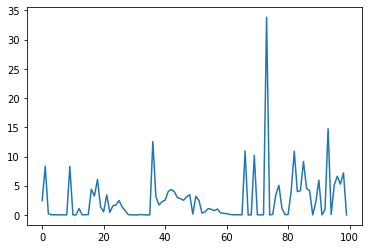

In [16]:
print( loss_graph)
plt.plot(loss_graph)

In [26]:
test_loss_graph = []

def test( model ,  celoss , l1loss , test_datas, test_labels): # parametrelere direk trainingi yapistir oyle olmasi lazim 
  with torch.no_grad():
    total = 0
    correct = 0 
    for i in range( 1000 ):
      total += 1 
      test_data = torch.Tensor(test_datas[i + 100 ][1] )
      #train_data = train_data.cuda(device = 'cuda:0')
      print( i  + 100 )
      test_label = test_labels[i+ 100 ][1]
      #print( "training laable : , " , test_label[i])
      #labels
      one_hot_vector = torch.zeros( (8)).cuda(device="cuda:0")
      #print( train_label[0] )
      one_hot_vector[classes[test_label[0]]] = 1
      #bounding box 
      bounding_box = torch.Tensor( [ float(test_label[1]) , float(test_label[2]) , float(test_label[3]) , float(test_label[4])  ]  )
      #print( bounding_box)
      bounding_box = torch.Tensor( bounding_box).cuda(device="cuda:0")
      #convert training datato  class
      classifier , out_bb = model(test_data)
      #print("one hot vector " ,  one_hot_vector.shape , "classifier " ,  classifier[0].shape )
      #print("out bb  " ,  out_bb.shape , "bounding box  " ,  bounding_box.shape )
      #print( "classifier" , classifier[0].shape)

      temp = torch.zeros((1))
      temp[0] = classes[test_label[0]]     
      #print("temp" , temp , "classifier" , classifier )
          
      new_classifier = torch.unsqueeze(classifier[0], 0)
      temp = temp.type(torch.LongTensor)
      temp = temp.cuda(device="cuda:0")
      max_index = torch.argmax(new_classifier)
      print( "max_index" , max_index)
      print("temp  " , temp.shape , "classifier " , new_classifier.shape   )
      if( max_index == temp ):
        correct += 1 
      loss_class = celoss(new_classifier, temp )
      loss_class = torch.sum(loss_class)
      loss_bb = l1loss(out_bb[0], bounding_box).sum(0)
      #print( loss_bb )
      loss_bb = loss_bb.sum()
      loss = loss_class + loss_bb/8
      loss = loss_class
      test_data = test_data.cpu()
      final_loss = loss.cpu()
      test_loss_graph.append(final_loss.detach().numpy() )
    print( "accuracy is === " , float(correct) / float(total) ) 

test(model , cross_entropy , l1loss , training_datas , labels )

100
torch.Size([16, 1]) tensor([[ 9.9946e-01],
        [-3.2932e-02],
        [-1.7343e-03],
        [ 1.2635e-03],
        [ 3.2932e-02],
        [ 9.9946e-01],
        [-8.7224e-04],
        [-7.6329e-04],
        [ 1.7421e-03],
        [ 8.2739e-04],
        [ 9.9987e-01],
        [ 1.5968e-02],
        [-1.2657e-03],
        [ 7.9138e-04],
        [-1.5967e-02],
        [ 9.9987e-01]], device='cuda:0')
g  torch.Size([2000, 16])  point cloud  torch.Size([2000, 4])
torch.Size([2000, 20])  H1 
T3 shape  torch.Size([2000, 2])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.0052e-09, -1.1919e-09, -1.3101e-09,  2.8393e-10],
        [ 6.0104e-09, -2.3838e-09, -2.6203e-09,  5.6785e-10],
        ...,
        [ 6.1005e-01,  7.3200e-01, -9.6392e-01,  2.9145e-01],
        [ 6.1005e-01,  7.3200e-01, -9.6392e-01,  2.9145e-01],
        [ 6.1005e-01,  7.3200e-01, -9.6392e-01,  2.9145e-01]], device='cuda:0')
interpolation  tensor([[ 2.2018,  2.0734, -1.0488,  0.1940],
        [ 2.2018,  2.0734, -1.0488,  0.1940],
        [ 2.2018,  2.0734, -1.0488,  0.1940],
        ...,
        [ 2.0908,  0.6481, -1.4789,  0.2994],
        [ 2.0669,  0.7311, -1.4762,  0.3029],
        [-3.0160,  0.3336, -1.1172,  0.3400]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-21.0422,  -2.7458,  14.7707,  -3.6778,  -4.9734, -13.2825,  -9.7237,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5544, -0.5489, -0.2695,  0.0792],
        [-0.9089, -0.8998, -0.4418,  0.1299],
        ...,
        [-2.2200,  0.2741, -0.9656,  0.2668],
        [-2.2200,  0.2741, -0.9656,  0.2668],
        [-2.2200,  0.2741, -0.9656,  0.2668]], device='cuda:0')
interpolation  tensor([[-0.5122, -6.1728, -1.3548,  0.3120],
        [-0.7228, -6.6254, -1.2627,  0.3480],
        [-0.7227, -6.6254, -1.2627,  0.3480],
        ...,
        [-0.5321, -2.6471, -1.0764,  0.2774],
        [-0.6378, -2.5930, -1.0813,  0.2778],
        [-0.8552, -1.7418, -1.1366,  0.2860]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-19.9092,  -2.5007,  14.0546,  -3.4191,  -5.1200, -12.8777,  -9.0655,
          -2.9333],
        [  1.2808,  -1.0096,  -0.4893,  -1.2438,   1.1751,   1.0441,  -1.9420

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3460, -0.7405, -0.2497,  0.0388],
        [-0.5941, -1.2715, -0.4287,  0.0666],
        ...,
        [-1.7202, -0.2178, -0.8998,  0.2537],
        [-1.7202, -0.2178, -0.8998,  0.2537],
        [-1.7202, -0.2178, -0.8998,  0.2537]], device='cuda:0')
interpolation  tensor([[-3.2766,  0.0264, -1.3972,  0.3160],
        [-1.9235, -1.3657, -1.3771,  0.2030],
        [-1.9470, -1.3673, -1.3820,  0.1926],
        ...,
        [-4.0658, -0.3366, -0.8918,  0.3200],
        [-4.0658, -0.3366, -0.8918,  0.3200],
        [ 3.5100,  1.3352, -1.2208,  0.3200]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-21.6402,  -2.7822,  15.2680,  -3.8710,  -4.8605, -13.1252, -10.6189,
          -4.3774],
        [  1.5231,  -1.2616,  -0.4147,  -1.6532,   0.8897,   0.7292,  -2.4400

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.7424e-12,  4.3990e-12, -1.0686e-12,  4.1300e-13],
        [ 3.4847e-12,  8.7980e-12, -2.1371e-12,  8.2601e-13],
        ...,
        [-2.9710e-01, -1.2771e+00, -1.0331e+00,  2.8896e-01],
        [-2.9710e-01, -1.2771e+00, -1.0331e+00,  2.8896e-01],
        [-2.9710e-01, -1.2771e+00, -1.0331e+00,  2.8896e-01]], device='cuda:0')
interpolation  tensor([[-7.3448, -3.0704, -0.4348,  0.3500],
        [-7.3448, -3.0704, -0.4348,  0.3500],
        [-7.3448, -3.0704, -0.4348,  0.3500],
        ...,
        [-1.0112, -6.6847, -1.6080,  0.2361],
        [-1.0096, -6.6846, -1.6080,  0.2361],
        [-0.1494, -6.5698, -1.5886,  0.2160]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  1.0158,  -1.2382,  -0.1841,  -1.5517,   1.0568,   0.6950,  -2.4685,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.6237e-05,  1.9656e-06,  1.4680e-07,  3.6586e-07],
        [-3.2475e-05,  3.9312e-06,  2.9359e-07,  7.3172e-07],
        ...,
        [-9.9348e-01,  2.8269e-01, -1.2429e+00,  2.6574e-01],
        [-9.9348e-01,  2.8269e-01, -1.2429e+00,  2.6574e-01],
        [-9.9348e-01,  2.8269e-01, -1.2429e+00,  2.6574e-01]], device='cuda:0')
interpolation  tensor([[ 1.9356,  0.1484, -0.7828,  0.2780],
        [-7.6734,  2.5918, -0.1272,  0.2200],
        [-7.6734,  2.5918, -0.1272,  0.2200],
        ...,
        [ 2.3502,  6.8208, -1.0710,  0.2720],
        [ 2.3502,  6.8208, -1.0710,  0.2720],
        [ 1.0498,  9.7886, -0.5838,  0.2660]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-2.0482e+01, -2.5757e+00,  1.4408e+01, -3.4933e+00, -5.0430e+00,
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0843,  0.0619, -0.0509,  0.0052],
        [-0.1644,  0.1208, -0.0994,  0.0102],
        ...,
        [-0.3494,  3.0946, -1.5036,  0.2057],
        [-0.3494,  3.0946, -1.5036,  0.2057],
        [-0.3494,  3.0946, -1.5036,  0.2057]], device='cuda:0')
interpolation  tensor([[ 2.0612, -9.4598, -1.4332,  0.3900],
        [ 2.1317, -5.2276, -1.5512,  0.2776],
        [ 2.1290, -5.2238, -1.5514,  0.2775],
        ...,
        [18.1141, 22.3444, -0.1297,  0.0785],
        [18.1533, 22.4483, -0.1285,  0.0779],
        [ 5.8926, 16.0676, -0.7116,  0.0580]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-20.3031,  -2.5611,  14.2711,  -3.4504,  -5.0849, -13.0412,  -9.2047,
          -3.1311],
        [  2.4176,  -0.8958,  -0.9751,  -1.3550,   1.0165,   1.5308,  -1.9221

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.0899,  0.2885, -1.3171,  0.2460],
        [-1.0899,  0.2885, -1.3171,  0.2460],
        [-1.0899,  0.2885, -1.3171,  0.2460]], device='cuda:0')
interpolation  tensor([[ 1.3042,  8.3058, -1.3316,  0.2060],
        [ 1.3042,  8.3058, -1.3316,  0.2060],
        [ 1.3042,  8.3058, -1.3316,  0.2060],
        ...,
        [ 2.3164,  1.1646, -1.0012,  0.2180],
        [ 2.3164,  1.1646, -1.0012,  0.2180],
        [ 2.3164,  1.1646, -1.0012,  0.2180]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-20.6260,  -2.5820,  14.4945,  -3.5190,  -4.9894, -12.9597,  -9.5391,
          -3.4418],
        [  2.2332,  -1.0917,  -0.8798,  -1.4627,   0.8544,   1.0999,  -1.9214

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 7.5847e-19, -5.8330e-18, -2.2605e-18,  1.4723e-26],
        [ 1.5169e-18, -1.1666e-17, -4.5210e-18,  2.9445e-26],
        ...,
        [ 2.3386e-01,  1.8692e+00, -1.0407e+00,  2.7892e-01],
        [ 2.3386e-01,  1.8692e+00, -1.0407e+00,  2.7892e-01],
        [ 2.3386e-01,  1.8692e+00, -1.0407e+00,  2.7892e-01]], device='cuda:0')
interpolation  tensor([[ 1.0464, -4.6120, -0.7556,  0.1920],
        [ 1.0464, -4.6120, -0.7556,  0.1920],
        [ 1.0464, -4.6120, -0.7556,  0.1920],
        ...,
        [ 3.5726,  0.3516, -0.9796,  0.1760],
        [ 3.5726,  0.3516, -0.9796,  0.1760],
        [ 3.5726,  0.3516, -0.9796,  0.1760]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-16.4767,  -2.0110,  11.6083,  -2.9046,  -4.0752,  -9.8527,  -7.6396,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-7.4886e-08,  1.4352e-07, -7.8640e-10,  2.1191e-12],
        [-1.4977e-07,  2.8704e-07, -1.5728e-09,  4.2382e-12],
        ...,
        [-1.0786e+00,  1.6684e+00, -6.3016e-01,  2.1489e-01],
        [-1.0786e+00,  1.6684e+00, -6.3016e-01,  2.1489e-01],
        [-1.0786e+00,  1.6684e+00, -6.3016e-01,  2.1489e-01]], device='cuda:0')
interpolation  tensor([[-2.4082,  2.9096, -0.7542,  0.1620],
        [-2.5670,  2.5788, -0.6442,  0.1200],
        [-2.5670,  2.5788, -0.6442,  0.1200],
        ...,
        [ 0.4610,  3.3394, -0.8068,  0.1640],
        [ 0.4610,  3.3394, -0.8068,  0.1640],
        [ 0.4610,  3.3394, -0.8068,  0.1640]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-21.3124,  -2.7613,  14.9948,  -3.7516,  -4.9252, -13.2260, -10.0934,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 9.0493e-06,  1.5491e-05,  1.9558e-07,  1.1678e-06],
        [ 1.8099e-05,  3.0982e-05,  3.9115e-07,  2.3356e-06],
        ...,
        [ 6.1150e-01,  2.6652e-01, -7.7934e-01,  2.8130e-01],
        [ 6.1150e-01,  2.6652e-01, -7.7934e-01,  2.8130e-01],
        [ 6.1150e-01,  2.6652e-01, -7.7934e-01,  2.8130e-01]], device='cuda:0')
interpolation  tensor([[-0.0250, -4.2326, -0.6520,  0.2660],
        [ 0.3692, -2.5624, -0.5980,  0.2920],
        [ 0.3692, -2.5624, -0.5980,  0.2920],
        ...,
        [-2.2611, -1.1835, -1.1475,  0.2143],
        [-2.2617, -1.1834, -1.1474,  0.2143],
        [-1.0712, -1.0760, -1.0900,  0.2360]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-2.0596e+01, -2.5927e+00,  1.4491e+01, -3.5135e+00, -5.0248e+00,
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1646, -0.3567, -0.8538,  0.2506],
        [ 0.1646, -0.3567, -0.8538,  0.2506],
        [ 0.1646, -0.3567, -0.8538,  0.2506]], device='cuda:0')
interpolation  tensor([[ 0.4596, -1.0760, -0.3182,  0.2660],
        [ 0.4596, -1.0760, -0.3182,  0.2660],
        [ 0.4596, -1.0760, -0.3182,  0.2660],
        ...,
        [ 1.3956,  0.6050, -0.7108,  0.2780],
        [ 1.3956,  0.6050, -0.7108,  0.2780],
        [ 1.3956,  0.6050, -0.7108,  0.2780]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  1.2857,  -1.3899,  -0.1871,  -1.7905,   0.7780,   0.4011,  -2.6470,
          -4.3313],
        [-19.8263,  -2.3731,  13.9075,  -3.2339,  -5.0014, -12.5523,  -8.8707

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.1800e-06, -1.6496e-07, -3.2426e-07,  7.1815e-08],
        [-2.3600e-06, -3.2991e-07, -6.4851e-07,  1.4363e-07],
        ...,
        [ 2.5053e-01, -3.5255e-02, -8.3364e-01,  2.8219e-01],
        [ 2.5053e-01, -3.5256e-02, -8.3364e-01,  2.8219e-01],
        [ 2.5053e-01, -3.5257e-02, -8.3364e-01,  2.8219e-01]], device='cuda:0')
interpolation  tensor([[-0.3080,  1.9170, -0.6350,  0.3260],
        [-0.6654,  2.8418, -0.4450,  0.2520],
        [-0.6654,  2.8418, -0.4450,  0.2520],
        ...,
        [-0.7528,  0.1650, -0.7018,  0.2580],
        [-0.7528,  0.1650, -0.7018,  0.2580],
        [ 0.4740,  0.4196, -0.4614,  0.2680]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-20.0154,  -2.4294,  14.1080,  -3.3569,  -5.0285, -12.6402,  -9.1872,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 6.4151e-17,  9.4288e-18,  6.9528e-19,  1.1974e-18],
        [ 1.2830e-16,  1.8858e-17,  1.3906e-18,  2.3949e-18],
        ...,
        [ 7.7130e-01,  1.5659e+00, -1.0304e+00,  2.7346e-01],
        [ 7.7130e-01,  1.5659e+00, -1.0304e+00,  2.7346e-01],
        [ 7.7130e-01,  1.5659e+00, -1.0304e+00,  2.7346e-01]], device='cuda:0')
interpolation  tensor([[ 2.6680, -5.2114, -0.5770,  0.3380],
        [ 2.6680, -5.2114, -0.5770,  0.3380],
        [ 2.6680, -5.2114, -0.5770,  0.3380],
        ...,
        [-8.4922, -0.2812,  0.0364,  0.3780],
        [-8.4922, -0.2812,  0.0364,  0.3780],
        [-8.4922, -0.2812,  0.0364,  0.3780]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-16.4800,  -0.7190,  10.8047,  -1.4232,  -3.3428,  -8.1029,  -5.3620,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 9.0351e-14, -7.4064e-14, -4.4085e-14,  8.8120e-15],
        [ 1.8070e-13, -1.4813e-13, -8.8169e-14,  1.7624e-14],
        ...,
        [-1.8963e-01,  8.2928e-01, -1.3201e+00,  2.6496e-01],
        [-1.8963e-01,  8.2928e-01, -1.3201e+00,  2.6496e-01],
        [-1.8963e-01,  8.2928e-01, -1.3201e+00,  2.6496e-01]], device='cuda:0')
interpolation  tensor([[-3.2208, -3.1952, -1.5838,  0.2180],
        [-3.2208, -3.1952, -1.5838,  0.2180],
        [-3.2208, -3.1952, -1.5838,  0.2180],
        ...,
        [-0.1596,  3.1649, -1.2847,  0.2993],
        [-0.1689,  3.1769, -1.2838,  0.2994],
        [-2.2682,  2.1116, -1.3292,  0.2960]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-19.9708,  -2.4543,  14.0570,  -3.3527,  -5.0681, -12.7759,  -9.0579,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8300, -0.7122, -1.3172,  0.3010],
        [-0.8300, -0.7122, -1.3172,  0.3010],
        [-0.8300, -0.7122, -1.3172,  0.3010]], device='cuda:0')
interpolation  tensor([[ 4.6860,  6.7974, -0.6462,  0.2760],
        [ 4.6860,  6.7974, -0.6462,  0.2760],
        [ 4.6860,  6.7974, -0.6462,  0.2760],
        ...,
        [-0.5968,  1.1758, -0.6332,  0.3560],
        [-0.5968,  1.1758, -0.6332,  0.3560],
        [-0.5968,  1.1758, -0.6332,  0.3560]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  1.4211,  -1.3026,  -0.3248,  -1.6712,   0.8344,   0.5855,  -2.4488,
          -4.1425],
        [-20.0012,  -2.4562,  14.0637,  -3.3558,  -5.0579, -12.7186,  -9.0763

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 6.3650e-17,  3.8028e-17,  8.2990e-19,  2.0633e-18],
        [ 1.2730e-16,  7.6057e-17,  1.6598e-18,  4.1266e-18],
        ...,
        [-6.1167e-01,  1.6861e+00, -1.0664e+00,  2.7932e-01],
        [-6.1167e-01,  1.6861e+00, -1.0664e+00,  2.7932e-01],
        [-6.1167e-01,  1.6861e+00, -1.0664e+00,  2.7932e-01]], device='cuda:0')
interpolation  tensor([[ 2.3892,  5.3018, -1.5004,  0.3760],
        [ 2.3892,  5.3018, -1.5004,  0.3760],
        [ 2.3892,  5.3018, -1.5004,  0.3760],
        ...,
        [ 4.2454, -3.5674, -1.0240,  0.2520],
        [ 4.2454, -3.5674, -1.0240,  0.2520],
        [ 4.2454, -3.5674, -1.0240,  0.2520]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-13.4335,  -1.8692,   9.4419,  -2.2523,  -3.2840,  -9.1512,  -6.0668,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4436e-17,  8.7259e-17, -1.0466e-17,  2.5634e-18],
        [ 2.8871e-17,  1.7452e-16, -2.0932e-17,  5.1269e-18],
        ...,
        [ 1.3428e+00,  3.9154e-01, -9.6916e-01,  2.8248e-01],
        [ 1.3428e+00,  3.9154e-01, -9.6916e-01,  2.8248e-01],
        [ 1.3428e+00,  3.9154e-01, -9.6916e-01,  2.8248e-01]], device='cuda:0')
interpolation  tensor([[10.0798, -2.5392, -0.7728,  0.2360],
        [10.0798, -2.5392, -0.7728,  0.2360],
        [10.0798, -2.5392, -0.7728,  0.2360],
        ...,
        [ 5.3592, -1.9554, -1.0866,  0.3320],
        [ 5.3592, -1.9554, -1.0866,  0.3320],
        [ 5.3592, -1.9554, -1.0866,  0.3320]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-10.8912,  -1.9718,   7.9271,  -2.5457,  -2.7501,  -7.2873,  -6.0679,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.8412e-17, -1.7627e-17, -2.4702e-18,  1.9493e-18],
        [ 7.6823e-17, -3.5254e-17, -4.9405e-18,  3.8987e-18],
        ...,
        [ 6.6971e-01,  7.9127e-01, -9.9343e-01,  2.7777e-01],
        [ 6.6971e-01,  7.9127e-01, -9.9343e-01,  2.7777e-01],
        [ 6.6971e-01,  7.9128e-01, -9.9343e-01,  2.7777e-01]], device='cuda:0')
interpolation  tensor([[-0.6214,  0.2222, -0.8818,  0.2000],
        [-0.6214,  0.2222, -0.8818,  0.2000],
        [-0.6214,  0.2222, -0.8818,  0.2000],
        ...,
        [-0.9120, -0.3694, -0.9776,  0.3520],
        [-0.9120, -0.3694, -0.9776,  0.3520],
        [-0.9120, -0.3694, -0.9776,  0.3520]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-18.4282,  -2.0951,  12.8509,  -2.8365,  -5.0922, -11.8286,  -7.7228,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.9395e-17, -6.7342e-17, -3.7448e-18,  1.4905e-18],
        [-3.8790e-17, -1.3468e-16, -7.4897e-18,  2.9810e-18],
        ...,
        [ 5.7615e-01,  1.6165e+00, -9.9817e-01,  2.7797e-01],
        [ 5.7615e-01,  1.6165e+00, -9.9817e-01,  2.7797e-01],
        [ 5.7615e-01,  1.6165e+00, -9.9817e-01,  2.7797e-01]], device='cuda:0')
interpolation  tensor([[ 1.9716,  0.1396, -1.1066,  0.3320],
        [ 1.9716,  0.1396, -1.1066,  0.3320],
        [ 1.9716,  0.1396, -1.1066,  0.3320],
        ...,
        [ 3.3672, -1.6456, -1.0932,  0.2720],
        [ 3.3672, -1.6456, -1.0932,  0.2720],
        [ 3.3672, -1.6456, -1.0932,  0.2720]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[  0.4866,  -1.5153,   0.3710,  -2.0109,   0.8301,  -0.0783,  -3.2743,
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


T shape  torch.Size([2000, 2])
1.0
torch.Size([16384, 2])
ballquerynormal tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.5042e-19, -1.3282e-17, -2.2160e-18,  2.5902e-19],
        [-1.3008e-18, -2.6564e-17, -4.4321e-18,  5.1803e-19],
        ...,
        [ 8.3507e-01,  1.7353e+00, -1.0387e+00,  2.8392e-01],
        [ 8.3507e-01,  1.7353e+00, -1.0387e+00,  2.8392e-01],
        [ 8.3508e-01,  1.7353e+00, -1.0387e+00,  2.8392e-01]], device='cuda:0')
interpolation  tensor([[-0.6142,  8.5558, -1.4382,  0.3460],
        [-0.6142,  8.5558, -1.4382,  0.3460],
        [-0.6142,  8.5558, -1.4382,  0.3460],
        ...,
        [-3.1868,  3.3694, -1.0554,  0.3100],
        [-3.1868,  3.3694, -1.0554,  0.3100],
        [-3.1868,  3.3694, -1.0554,  0.3100]], device='cuda:0')
x1121  torch.Size([3, 32, 32])
asda  torch.Size([3, 32, 32])
multiple image shape  torch.Size([3, 1280, 384])
classifier tensor([[-20.6151,  -2.6302,  14.4891,  -3.5493,  -5.0420, -13.1241,  -9.4602,
 

['Car', '459.33', '179.71', '505.68', '227.30', '1.37']


[array(0., dtype=float32),
 array(1.1920928e-07, dtype=float32),
 array(0., dtype=float32),
 array(2.3896198, dtype=float32),
 array(1.1920928e-07, dtype=float32),
 array(1.1920928e-07, dtype=float32),
 array(19.48394, dtype=float32),
 array(2.9802277e-06, dtype=float32),
 array(0., dtype=float32),
 array(17.856205, dtype=float32),
 array(6.48501, dtype=float32),
 array(1.1920928e-07, dtype=float32),
 array(14.147557, dtype=float32),
 array(19.125027, dtype=float32),
 array(1.4196315, dtype=float32),
 array(12.726, dtype=float32),
 array(10.67731, dtype=float32),
 array(17.943132, dtype=float32),
 array(1.0709794, dtype=float32),
 array(1.1920928e-07, dtype=float32)]

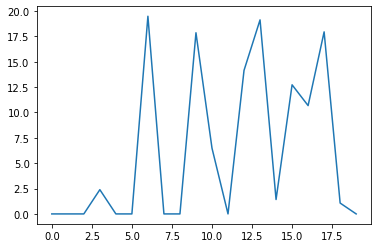

In [18]:
print(labels[101][1])
plt.plot(test_loss_graph)
test_loss_graph